# Skipets dynamikk, løst med numerikk

Dato = 14.03.2022
Prosjekt: teknisk fysikk

Denne prosjektoppgaven modellerer et skip med den hensikt å studere dens dynamikk på vannet. Skipets bevegelse påvirkes av faktorer som vær, vind, bølger, last mm. Disse tilnærmes og implementes for å kunne studere egenskaper ved skipet og ulike kriterier for stabilitet.
 
De gitte problemstillingene gjør oss nødt til å løse differensiallikninger. Dette blir gjort ved hjelp av ulike numeriske metoder. Enkelte av likningene lar seg løse analytisk som gir oss mulighet til å sammenligne de numeriske metodene mot de faktiske verdiene samt med hverandre. Dette gir oss gode muligheter for å diskutere metodene.  
 
Vi har 3 ulike funksjoner for å løse differensiallikningene til skipet. En for hver av de to oppgavene, og en for den kreative. ODE-løserne er hentet fra *Numerical solutions of ordinary differential equations* men modifisert for å tilpasses vår problemstilling. Koden er kommentert.
 
Det er blitt gjort flere begrensninger for å gjøre problemene betydelig enklere. Begrensinger og forenklinger vil avklares i forkant av de ulike kodene. Til å starte med er globale verdier for senere bruk definert, og relevante biblioteker importert. Vi har kodet prosjektet i Python, og besvart alle oppgavene. Det refereres til ligningene i oppgaveteksten ved nummerering.
 


## Skipsmodellen

I oppgaven ser vi på et kompakt skip som vugger om en akse i skipets lengderetning. Skipet er formet som en halvsirkel og har konstant massetetthet. Når skipet vugger i vannet vil den fortrengte vannmengden til skipet variere. Vi ser bare på båten i to dimensjoner, slik at den bare har en lengde og en bredde, men ingen dybde. Det innføres et tenkt koordinatsystem slik at vi kan holde styr på hvor båten befinner seg til en hver tid. Særlig vil vi fokusere på hvor massesenteret er, og eventuell last, i oppgave 2. y = 0 defineres til å være i vannflaten. Båten vil kunne kantre under gitte betingelser. Akkurat hvilke betingelser som må være oppfylt er noe av det vi ønsker å studere nærmere i løpet av prosjektet. 





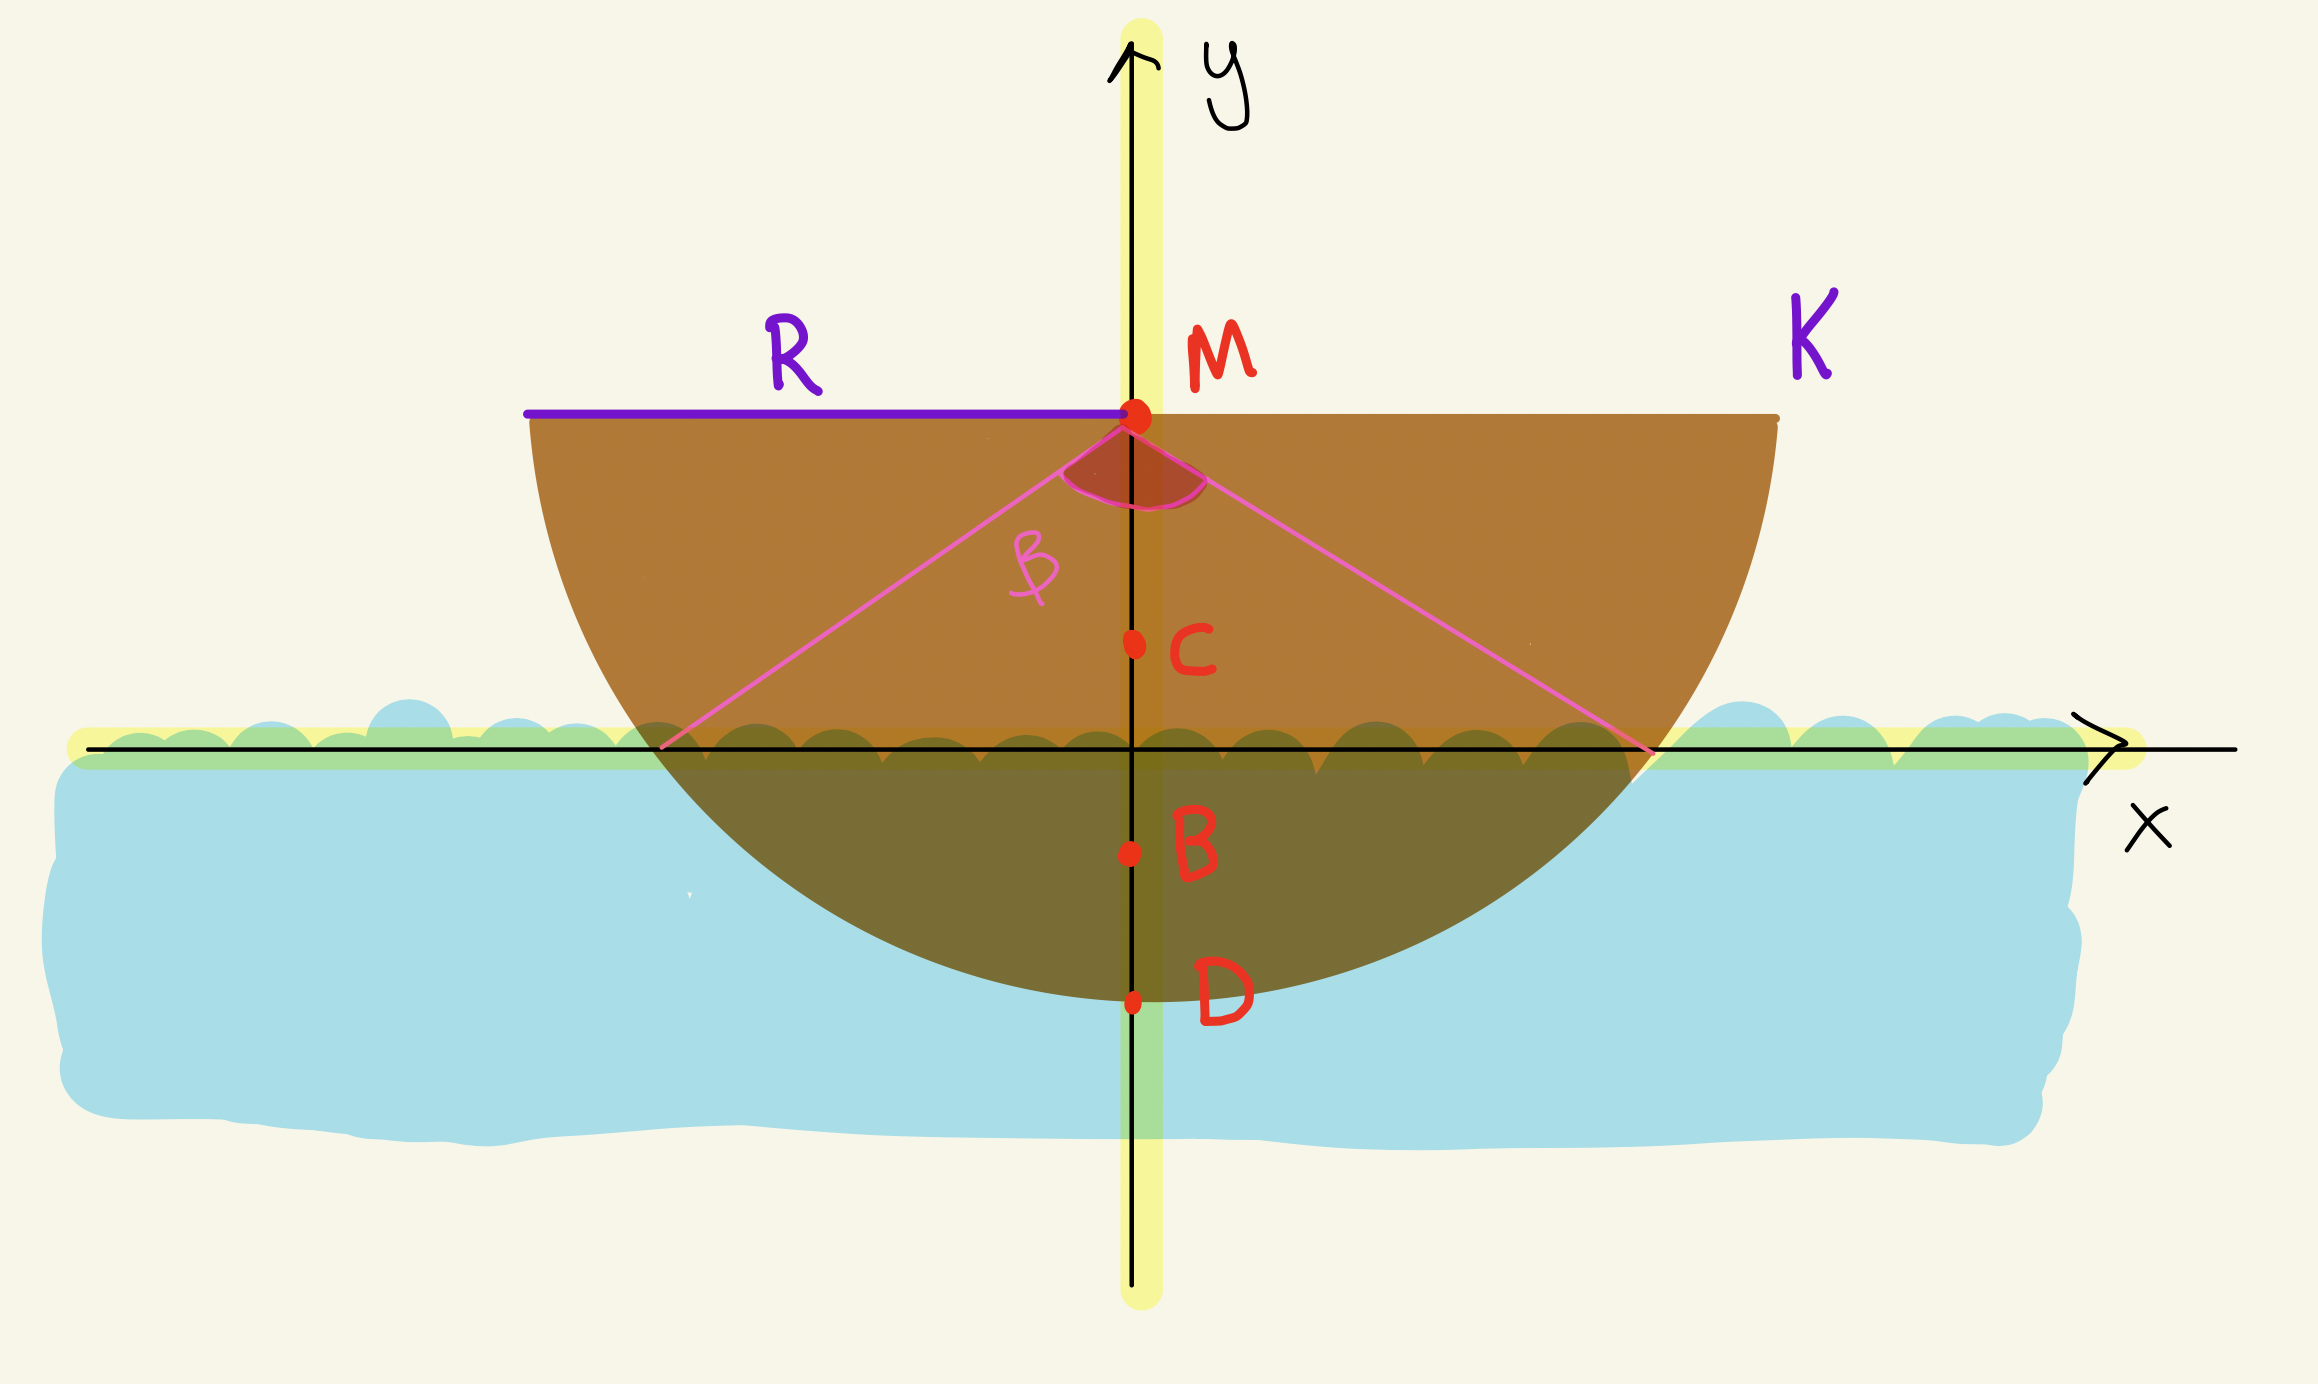

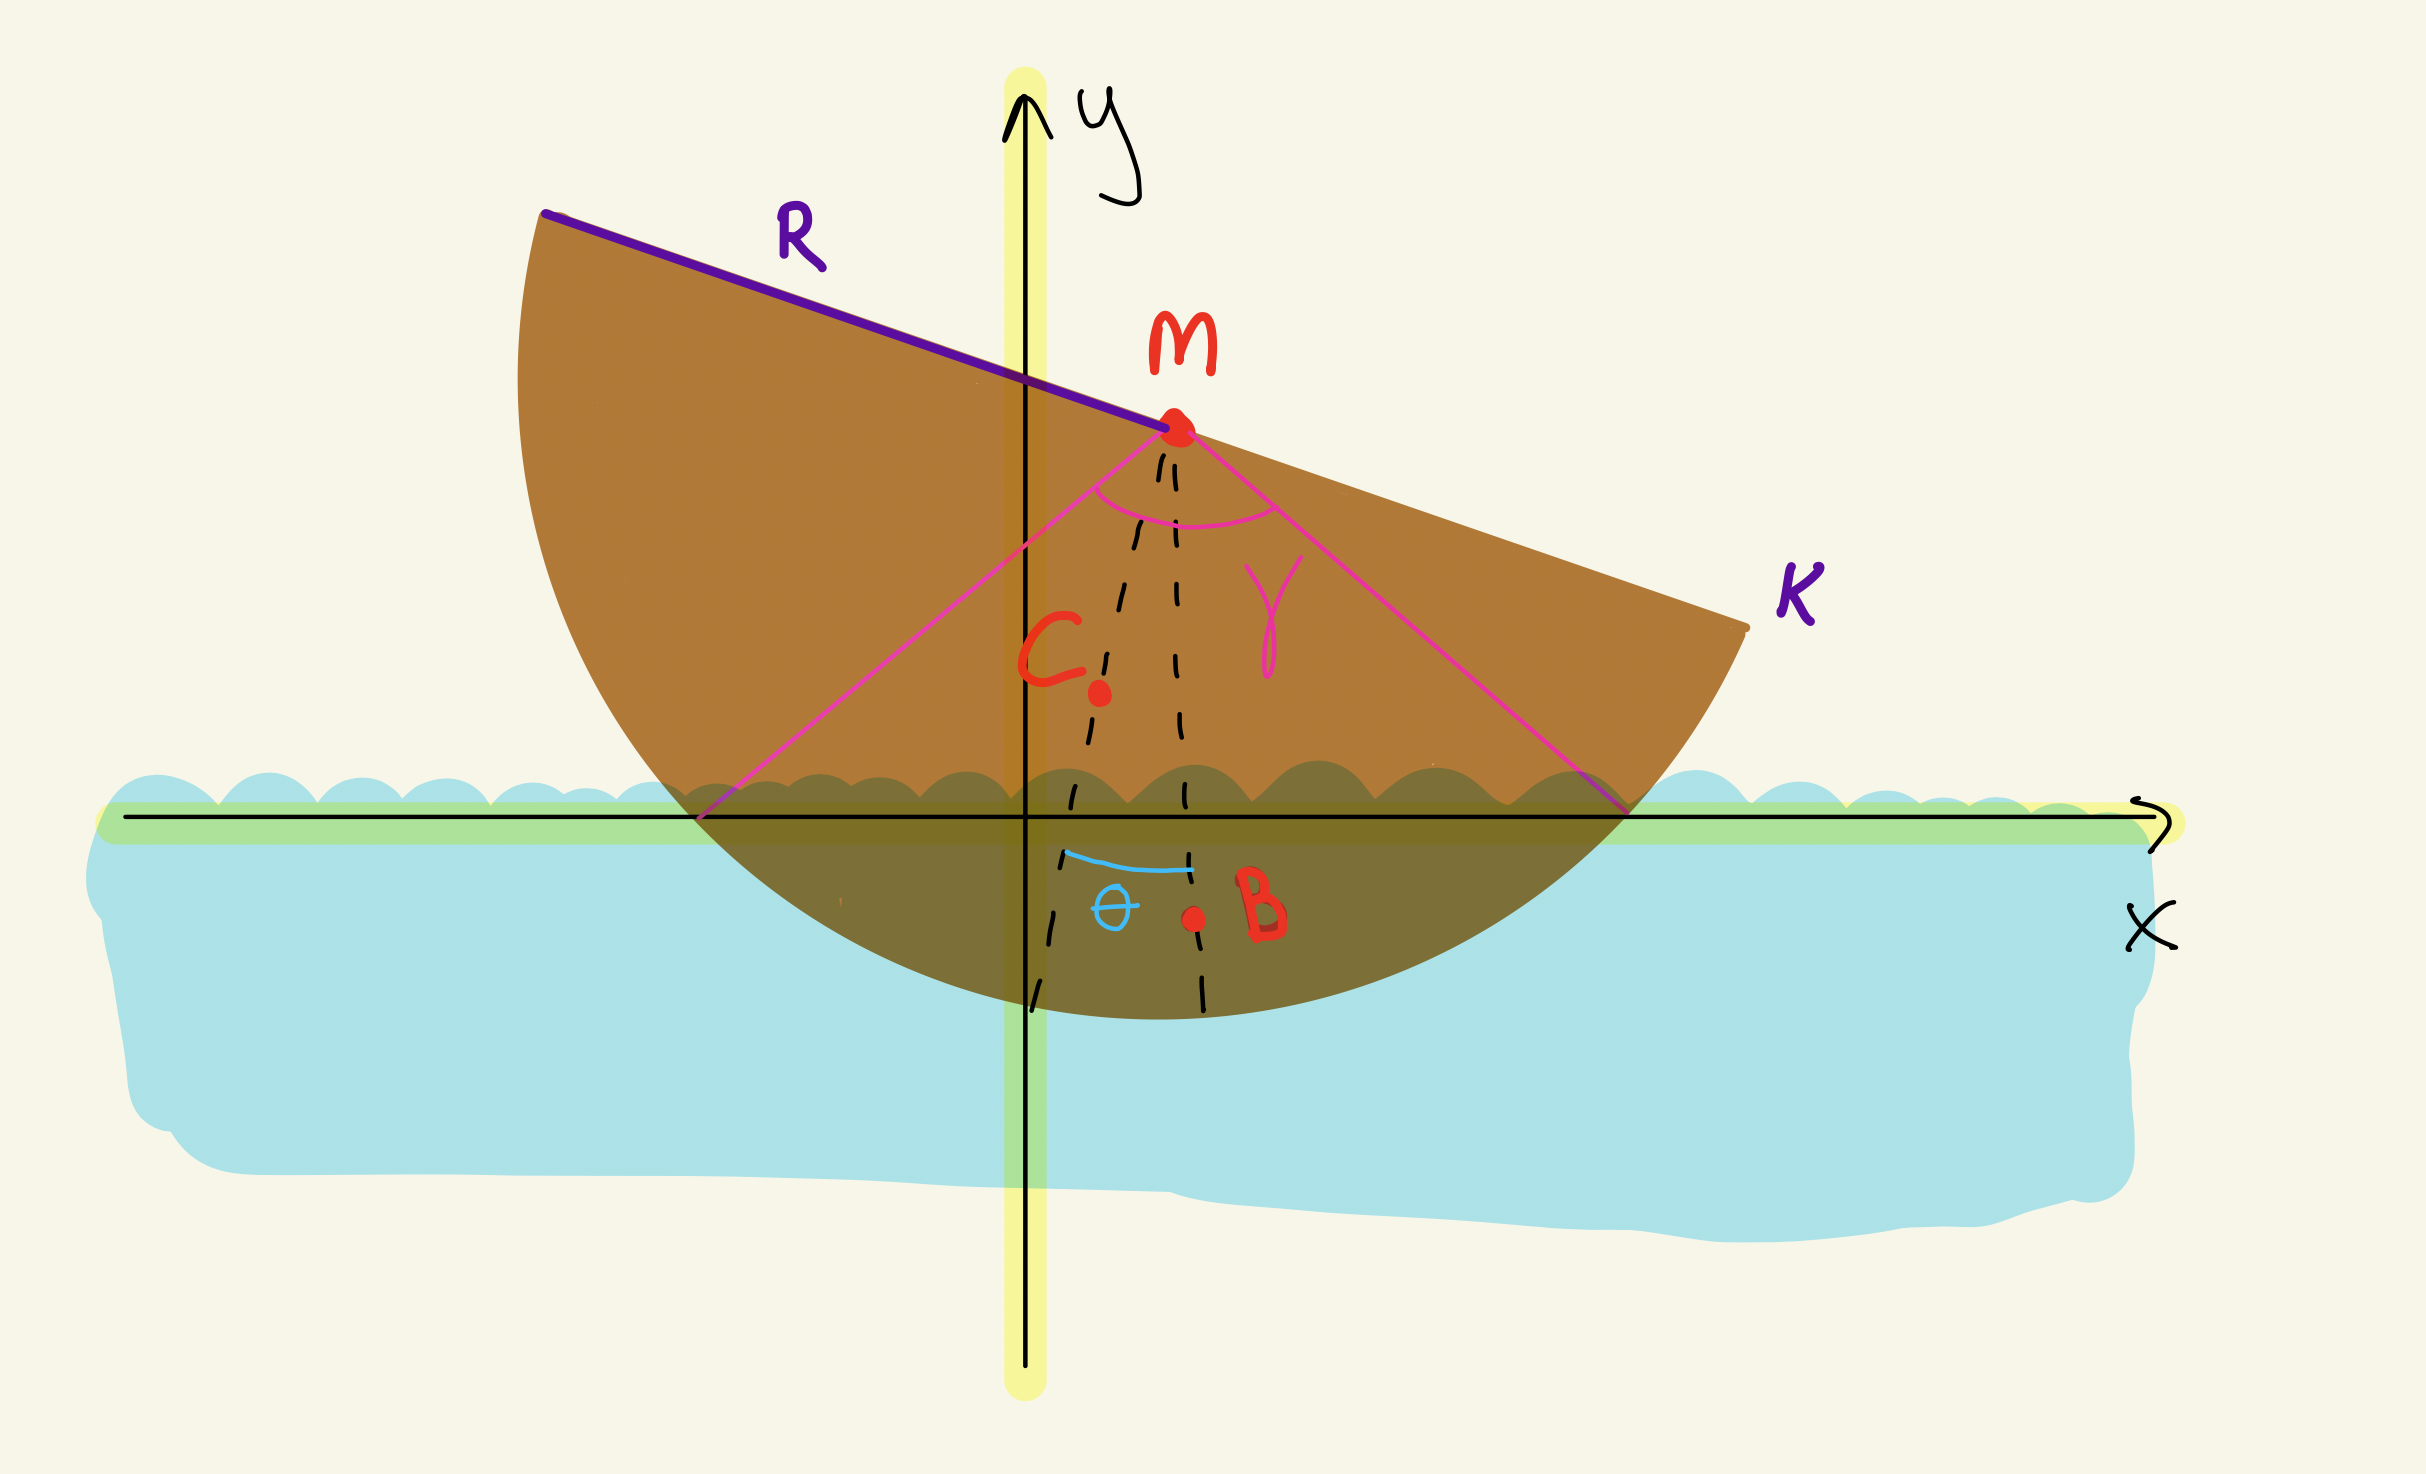

##### Parametrene vi bruker er: 

C = Skipets massesenter <br>
$\sigma_0$ = Vannets tetthet<br>
$\sigma$ = Skipets tetthet<br>
R = Skipets radius<br>
$A_S$ = Skipets tversnitt<br>
h = Høydeforskjellen mellom metasenteret og massesenteret<br>
M = Dekkets midtpunkt (metasenter)<br>
g = Graviditetskonstanten<br>
B = Oppdriftsenter<br>
D = skipets dypeste punkt<br>
K = skipets kant <br>
$I_C$ = Treghetsmomentet til båten<br>
$m_L$ = Massens last<br>
$k_f$ = Friksjonskoeffisienten<br>
$\omega_w$ = Frekvensen til den harmoniske kraften<br>
$\gamma$ = Vinkelen fra vannoverflatene på enden av skipet til metasenter<br>
$\beta $ = gamma ved likevekt<br>
A = Arealet av fortrengt vann<br>
$F_0$ = Amplituden til den harmoniske kraften<br>
$\theta$ = rotasjonsvinkelen <br>
$\omega_0$ = vinkelfrekvens harmonisk oscillator

### Kreftene som virker på skipet

På skipet vil det til sammen virke 4 ulike krefter. I første oppgave ser vi kun på de to første, mens i oppgave to vil alle fire kreftene inkluderes.

#### Indre krefter
 
1.  Gravitasjonen $F_g$ påvirker både skip og last på skipet. Denne virker nedover og vi har satt gravitasjonskontanten til å være lik 9.81.
2.  Oppdriftskraften $F_b$ (b for buoyancy) virker på båten og er proporsjonal med arealet av det fortrengte vannet. Kraften virker i oppdriftsenteret B, som tilsvarer tyngdepunktet til det fortrengte vannet
 
#### Ytre krefter<br>
3.  Friksjonskrefter $F_B$ mellom skip og vannet. Denne er proporsjonal med arealet av skipets grenseflate mot vann og grenseflatens vinkelhastighet. Kraften angriper i D. $k_f$ er en koeffisient.
 
4.  Værkrefter, $F_w$, som kommer som følge av vind og bølger. Den er satt til å være en harmonisk horisontalt rettet kraft på tvers av lengderetningen.
 
 
Det er verdt å nevne at begge de to ytre kreftene vi regner med er tilnærminger til virkeligheten. Grunnen til at vi må tilnærme er for å få mer håndterlige utregninger, kjøretider og kode.

## Oppgave 1

### Vinkelen ved likevekt
#### Oppgave 1a

I førsteomgang ønsker vi å finne $\beta$. Siden vi holder massetettheten konstant (noe den typisk også er) kan vi enkelt finne sektorvinkelen i likevekt, $\beta$. Dette gjøres ved å løse følgende likning: <br>

$\beta - sin(\beta) = \frac{\pi \cdot \sigma }{\sigma_0}$ $\hspace{3cm}(3)$ <br>
<br>
Her bruker vi bisection metoden. Dette gjør vi da metoden er veldig effektiv for å løse ikke-lineære problemer med en løsning på et gitt intervall. Bisection fungerer for enhver kontinuerlig funksjon på et intervall der verdien av funksjonen endrer fortegn innenfor intervallet. Metoden fungerer slik at intervallet halveres for enhver iterasjon for deretter å fortsette med delivtervallet som fortsatt gir en negativ og en positiv endeverdi. 

In [1]:
#Importerer nødvendige
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

import time
from numpy.linalg import solve, norm    # Solve linear systems and compute norms

In [107]:
#Parametere
sigma0 = 1000 #massetettheten til vann per lengdeenhet (kg/m^2)
sigma = 500 #massetettheten til skipet per lengdeenhet (kg/m^2)
R = 10 #radiusen (m)
A_s = 0.5*np.pi*R**2 #skipets tverrsnitt (m^2)
m = A_s*sigma # massen til skipet (m)
h = 4*R/(3*np.pi) #høyden fra skipets massesenter til dekkets midtpunkt (m)
A0 = sigma*np.pi*R**2/(2*sigma0) #arealet til fortrengt vann /m^2)
g = 9.81 #gravitasjonskonstanten (m/s^2)
Ic = 1/2*m*R**2*(1-32/(9*(np.pi)**2)) #Skipets treghetsmoment med akse gjennom C (kg*m^2)
w0global = np.sqrt(m*g*h/Ic) #egenfrekvens til harmonisk oscillator (rad/s)

In [3]:
#Oppgave 1a

def bisection(f, a, b, sigma, tol=1.e-6, max_iter = 100):
    ''' Solve the scalar equation f(x)=0 by bisection 
    Input:
        f:        Funksjonen. 
        a, b:     Interavall: 
        sigma:    Massetetthet til skipet (vil variere i senere oppgaver)
        tol :     Toleransen
        max_iter: Maximum antall iterasjoner
    Output:
        the root and the number of iterations.
    '''
    fa = f(a, sigma)
    fb = f(b, sigma)

    assert fa*fb<0, 'Error: f(a)*f(b)>0, there may be no root in the interval.'
    
    for k in range(max_iter):
        c = 0.5*(a+b)                 # The midpoint
        fc = f(c, sigma)                   
        #print(f"k ={k:3d}, a = {a:.6f}, b = {b:.6f}, c = {c:.6f}, f(c) = {fc:10.3e}")
        if abs(f(c, sigma)) < 1.e-14 or (b-a) < 2*tol:     # Dersom vi har et svar innenfor vår tolleranse
            break #Så returnerer vi verdiene
        elif fa*fc < 0:               
            b = c                     # There is a root in [a, c]
        else:
            a = c                     # There is a root in [c, b]  
    #print(f"k ={k:3d}, a = {a:.6f}, b = {b:.6f}, c = {c:.6f}, f(c) = {fc:10.3e}")
    return c, k


def f(beta, sigma):                   # Define the function
    return beta - np.sin(beta) - np.pi*sigma/sigma0  #Funksjonen er definert der likning (3) settes lik 0. 
a, b = 0, np.pi              # Intervallet. Dersom vinkelen hadde oversteget pi radianer, ville båten vært under vann. 
beta, nit = bisection(f, a, b, sigma, tol=1.e-6) # Apply the bisecetion method

def radToDeg(rad): #Gjør om fra radianer til grader
    return rad*180/np.pi 


def degToRad(deg): #Gjør om fra radianer til grader
    return deg*np.pi/180

print("Vinkelen som beskriver hvor mye av skipet som er i kontakt med vann når skipet er i likevekt er {:.2f}".format(radToDeg(beta)),"grader")
print(f'Vi trenger {nit} iterasjoner for å få en løsning innenfor toleransen. \nDette viser at bisection metoden er veldig effektivt for et ikke-lineart problem som dette. Sin(x) + k har kun ett nullpunkt på intervallet [0, pi], og her angir k antall ganger vi må halvere intervallet for å få et svar med feil mindre enn toleransen vår. ')


Vinkelen som beskriver hvor mye av skipet som er i kontakt med vann når skipet er i likevekt er 132.35 grader
Vi trenger 21 iterasjoner for å få en løsning innenfor toleransen. 
Dette viser at bisection metoden er veldig effektivt for et ikke-lineart problem som dette. Sin(x) + k har kun ett nullpunkt på intervallet [0, pi], og her angir k antall ganger vi må halvere intervallet for å få et svar med feil mindre enn toleransen vår. 



Metoden er ikke veldig effektiv for mer komplekse problemer, men siden vi trenger såpass få iterasjoner spiller det en liten rolle hva kjøretiden for hver iterasjon er.
 
Vinkelen som beskriver hvor mye av skipet som er i kontakt med vann når skipet er i likevekt er 2.309882 radianer, som gir oss 132.4 grader. Dette er en relativt stor vinkel som betyr at en betydelig del av båten er i kontakt med vann. 



### Høyder over vannflata
#### Oppgave 1b

Vi ønsker å finne ulike høyder ved likevekt, som kan være nyttige å bruke i senere deler av prosjektet. Nå som vi har funnet $\beta$ vil det være enkelt å regne ut høydene som er gitt ved følgende ligninger: 

$y_M^0 = R \cdot cos(\beta/2)$ $\hspace{6cm}  (4a)$ <br>
$y_C^0 = y_M^0 - h$  $\hspace{6.9cm}  (4b)$ <br>
$y_B^0 = y_M^0 - 4 R sin^3(\beta/2)/3(\beta-sin(\beta))$  $\hspace{2.5cm}  (4c)$ <br>
$y_D^0 = y_M^0 - R $  $\hspace{6.8cm}  (4d)$ <br>



In [6]:
# Oppgave 1b
#Finner ulike høyder ved likevekt

def høyder(beta): #Sender inn startparameter for å finne variabler ved likevekt
    yM0 = R*np.cos(beta/2) #y-koordinaten til midtpunkt
    yC0 = yM0 - h #y-koordinaten til massesenter
    yB0 = yM0-4*R*(np.sin(beta/2))**3/(3*(beta-np.sin(beta))) #y-koordinaten til oppdriftssenteret
    yD0 = yM0 - R #y-koordinatet til bunnen 
    return yM0,yC0, yB0, yD0


yM0, yC0, yB0, yD0 = høyder(beta)

$y_M^0 = 4.0397$ <br>
$y_C^0 = -0.2044$<br>
$y_B^0 = -2.4579$<br>
$y_D^0= -5.9603$<br>

Her ser vi at blant annet massesenteret vil ligge under vannflaten ved likevekt. 

### Skipets bevegelse
#### Oppgave 1c

Videre i oppgave 1 skal vi gjøre noen forenklinger. For det første kan vi neglisjere bevegelsen til massesenteret, slik at hele skipets dynamikk kan beskrives av:

$\sum\tau = I_C \frac{d\omega}{dt} $ $\hspace{3cm}  (13)$ <br>

Dette vil si at de eneste kreftene vi tar hensyn til i de neste deloppgavene er tyngdekraften og oppdriftskraften:

$F_G = -mg \hspace{1cm}(y) $ $\hspace{6cm}  (14a)$ <br>
$F_B = A\cdot \sigma_0\cdot g \hspace{1cm}(y) $ $\hspace{5.3cm}  (14b)$ <br>

Det vil altså bare være buoyancy kraften som gir opphav til dreiemomentet, ettersom gravitasjonskraften virker i massesenteret. 

$\tau_B = -F_B\cdot h \cdot sin(\theta) \hspace{5cm} (15a)$<br> 

Vi skal også anta at mengden fortrengt vann er konstant. På denne måten er det kun dreiemomentet som gjør at båten beveger seg, og at $\theta$ dermed endrer seg. 

Videre vil vi bruke $\vec{w} = [\theta(t), \omega(t)]^T$ der $\omega = \frac{d\theta}{dt}$ <br>
Det er altså en todimensjonal vektor som inneholder henholdsvis alle $\theta$-verdiene og alle $\omega$-verdiene. Disse vil oppdateres gjennom nummerikk, når vi implementerer ulike metoder. Slik at vi kan iterere oss gjennom alle verdiene som stadig vil oppdateres. 

$$ \sum\tau = I_C \frac{d\omega}{dt} $$ <br>
dette gir 
$$ \frac{d\omega}{dt} = \frac{\sum\tau}{I_C}   $$


$\vec{f} = \frac{d\vec{w}(t)}{dt}$ <br>
Vi deriverer $\vec{w}(t)$ <br>
 
$\frac{dw}{dt} = [\frac{d\theta}{dt}, \frac{d\omega}{dt}]^T = [\omega, \frac{\sum\tau}{I_C}]^T$
$=[\omega, - \frac{F_B h\cdot sin(\theta)}{I_C}]^T
= [\omega, - \frac{A_0 \sigma_0  g h\cdot sin(\theta)}{I_C} ]^T$
<br>Dette gir oss <br>
$\vec{f} = [\omega(t), - \frac{A_0 \sigma_0  g h\cdot sin(\theta(t))}{I_C}]^T$

$\vec{f} = [\vec{w}[1], - \frac{A_0 \sigma_0  g h\cdot sin(\vec{w}[0])}{I_C}]^T$

In [9]:
#Oppgave 1c
def fVec(t, w): #parametre: tiden t, forrige fVev: w
    arr = np.array([w[1], -A0*sigma0*g*h*np.sin(w[0])/Ic]) #ny fVec
    return arr

### Eulers metode
#### Oppgave 1d

Vi kan starte med Eulers metode. Denne er veldig enkel å implementerere, og går ut på å gjøre en taylor-rekkeutvikling hvor man bare tar hensyn til de to første leddene. Vi antar at steglengden er så liten at resterende ledd kan neglisjeres. Eulers metode er av første orden og vi vil nå implementere denne for å finne hvordan vinkelen varierer med tiden. Metoden brukes på likning (13). Startsvinkelen blir satt til 20 grader med startsvinkelhastighet 0 rad/s. Vi plotter $\theta$ som funksjon av tid for de første 20 sekundene. 

Siden feilen er av første orden, vil vi få større feil jo lengre skrittstørrelse vi bruker. Euler er spesielt uegnet for harmoniske løsninger, og derfor er vi nødt til å velge en liten skrittstørrelse.
Jo større skrittlengder vi velger oss, jo mer vil Euler-metoden divergere, og vi får stor forskjell fra den (harmoniske) analytiske løsningen. 

Vi prøver oss frem med ulike verdier for steglengden: 0.1, 0.01 og 0.001. Vi har valgt å kalle disse "dt" i stedet for "h" som oppgaveteksten bruker. Dette er for å ikke blande steglengden og høyden. 

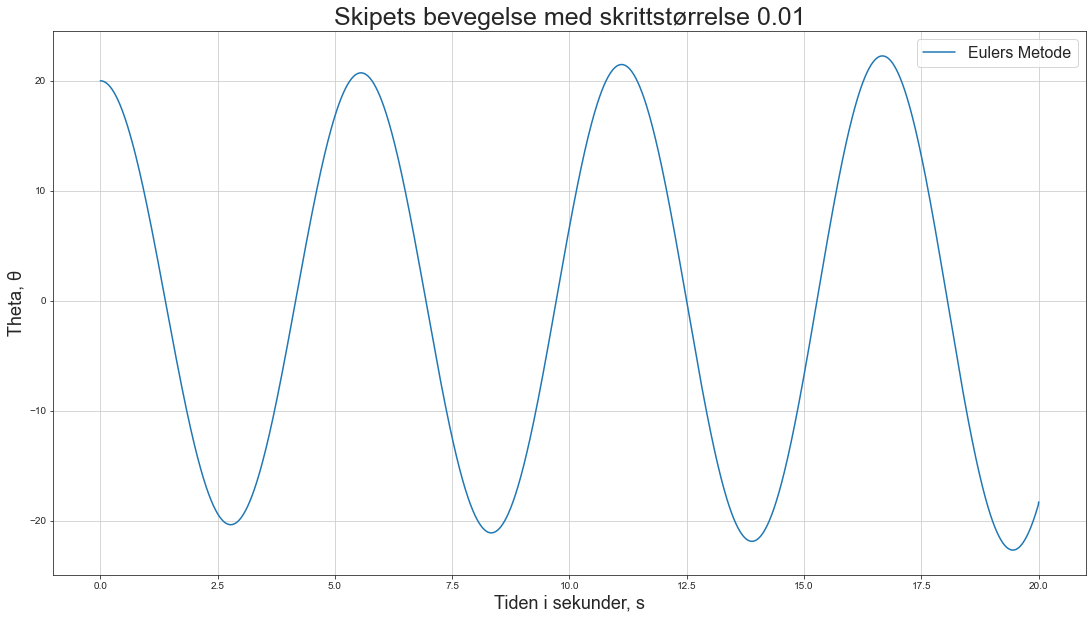

Med steglengde 0,01 tok det 0.04 sekunder


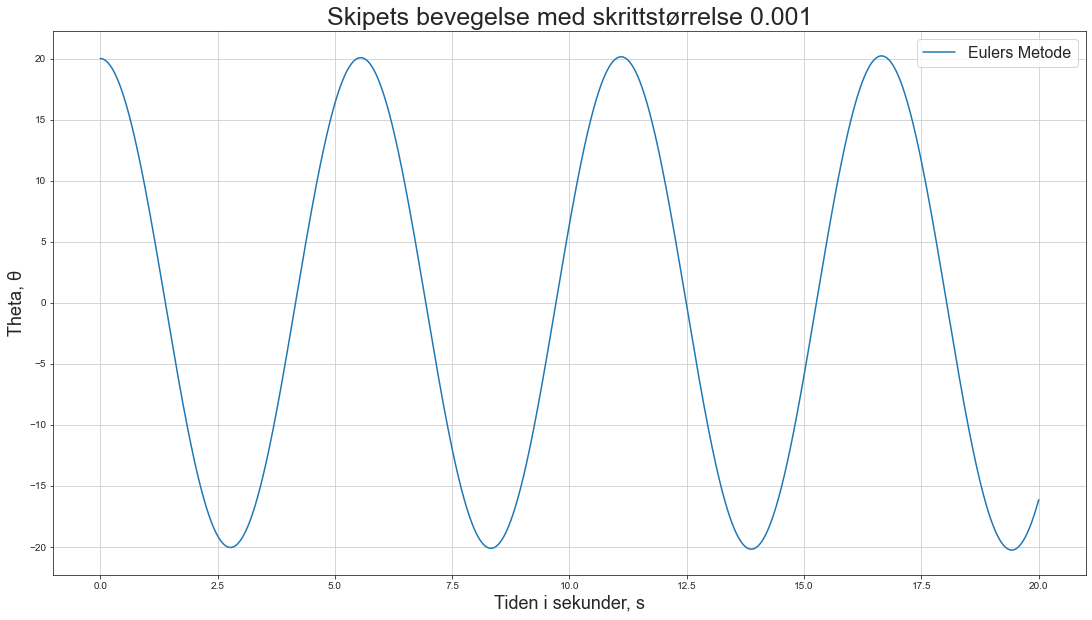

Med steglengde 0,001 tok det 0.41 sekunder


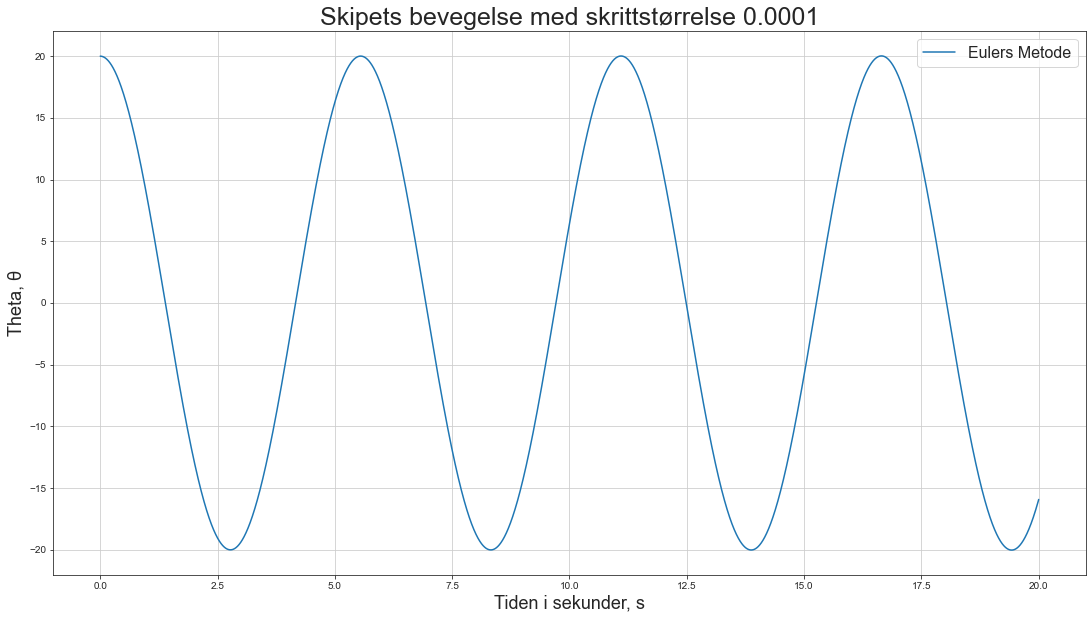

Med steglengde 0,0001 tok det 19.06 sekunder


In [109]:
# Oppgave 1d
w0 = np.array([degToRad(20), 0])   #w0 vektor
dt = 0.0001  #steglengde 
t0 = 0       #sekunder
tend = 20    #sekunder

def euler(f, t, w, dt):  # One step of the Euler method, kopiert fra "Numerical solutions of ordinary differential equations"
    w_next = w + dt*f(t, w)
    t_next = t + dt
    return t_next, w_next #returnerer neste t-verdi (tid) og w (vektor)
    

def ode_solver(f, t0, tend, warr, dt, method=euler): #kopiert fra "Numerical solutions of ordinary differential equations"
    '''
    Generic solver for ODEs
        y' = f(x,y), y(a)=y0
    Input: f, the integration interval t0 and tend, 
           the stepsize dt and the method of choice.  
       
    Output: Arrays with the x- and the corresponding y-values. 
    '''
    #Initializing:
    w_num = np.array([warr])    # Array for the solution y 
    t_num = np.array([t0])    # Array for the x-values

    tn = t0                # Running values for x and y
    wn = warr 

    while tn < tend:# - 1.e-10:           # Buffer for truncation errors    
        tn, wn = method(f, tn, wn, dt)    # Do one step by the method of choice
        # Extend the arrays for x and y
        w_num = np.concatenate((w_num, (np.array([wn]))))
        t_num = np.append(t_num,tn)
        if tn > tend: #Relevant for senere oppgaver, omgjør siste iterasjon slik at denne er lik vår tend. 
            tn, wn = method(f, tend, wn, dt)  
            w_num[-1] = wn
            t_num[-1] = tend      
    return t_num, w_num

#Hjelpefunksjon:
def hentTheta(w): #tar inn w-vektor, hvor theta er første indeksen i alle arrayene
    theta = np.zeros(len(w))
    for i in range(len(w)):
        theta[i] = radToDeg(w[i][0])  #lager en ny array med bare thetaverdiene
    return theta #theta-array returneres i grader

#Plottefunksjon
def plotTheta(t, w, metode, dt, masse = 0, last=False, friksjon = False): #plotte-funksjon
    theta = hentTheta(w)
    plt.figure()
    plt.plot(t, theta, label=metode)
    plt.grid()
    if last: #Last innføres senere
        plt.title("Skipets bevegelse, last med masse (i kg): {:.2f}".format(masse), fontsize=25)
    elif friksjon: 
        plt.title("Skipets bevegelse med friksjon, vind og bølger", fontsize = 25)
    else:
        plt.title(f'Skipets bevegelse med skrittstørrelse {dt}', fontsize=25) 
    plt.xlabel('Tiden i sekunder, s', fontsize=18)
    plt.ylabel('Theta, \u03B8', fontsize=18)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10)
    plt.rcParams['legend.fontsize'] = 16
    plt.legend(loc = 'upper right')
    plt.show()
    
t1 = time.time()
tArr001, wArr001 = ode_solver(fVec, t0, tend, w0, 0.01, method=euler) 
t2 = time.time()
t3 = time.time()
tArr0001, wArr0001 = ode_solver(fVec, t0, tend, w0, 0.001, method=euler) 
t4 = time.time()
t5 = time.time()
tArr00001, wArr00001 = ode_solver(fVec, t0, tend, w0, 0.0001, method=euler) 
t6 = time.time()
plotTheta(tArr001, wArr001, "Eulers Metode", 0.01)
print("Med steglengde 0,01 tok det {:.2f}".format(t2-t1), 'sekunder')
plotTheta(tArr0001, wArr0001, "Eulers Metode", 0.001)
print("Med steglengde 0,001 tok det {:.2f}".format(t4-t3), 'sekunder')
plotTheta(tArr00001, wArr00001, "Eulers Metode", 0.0001)
print("Med steglengde 0,0001 tok det {:.2f}".format(t6-t5), 'sekunder')

Her får vi et forenklet bilde av hvordan skipet vil bevege seg. Alle dissipative krefter er ignorert slik at vi ikke vil forvente noe demping i bevegelsen. De eneste kreftene som virker på båten er tyngdekraften og Boyancykraften. 

Energien er bevart for hele systemet, ettersom at det kun er konservative krefter som virker på båten. Vi skulle derfor trodd at amplituden til svingningene var konstant, men som vi kan se for dt = 0,01 øker amplituden for hver periode. Dette skyldes altså at steglengden er så stor, og Euler metoden blir dermed veldig unøyaktig, og vil divergere. Det kan virke som systemet får mer og mer energi, noe som er helt urealistisk. For å få bedre resultater må vi senke steglengden. Selv for dt = 0,001 ser vi noe økning i amplituden. Vi velger derfor å bruke dt = 0,0001 ettersom denne løsningen ser mer riktig ut. Selv om det ikke ser ut som denne løsningen øker energien noe særlig, kan vi være sikker på at om vi kjører den lengre vil amplituden øke. 

Likevel må vi ta i betraktning hvor lang tid det tar å kjøre kodene. Vi ser at med dt = 0,01 løser ODE_solveren ligningen på 0,04 sekunder. Dette er veldig raskt, men med tanke på hvor unøyaktig løsningen blir må vi minke steglengden. Med dt = 0,001 øker tilsvarende tiden ca. 10 ganger. Det er likevel veldig raskt, så vi kan si oss villige til å redusere dt igjen med en faktor 10, og ser at for dt = 0,0001 bruker koden over 19 sekunder. Etter som dette er relativt raskt, og plottet ser greit ut, sier vi oss fornøyd med dt = 0,0001, og trenger ikke teste for flere. 


### Vinkelapproksimasjon 
#### Oppgave 1e


Vi bruker approksimasjonen $\sin{\theta} = \theta$ som gjelder for $\theta << 1$. Denne tilnærmingen er pinlig mye brukt i fysikk, men vi vil se i denne oppgaven at det kan rettferdiggjøres. Vi løser likningen for båtens vinkelutslag $\theta$:

$-mgh\theta = I_C\cdot \ddot{\theta} \hspace{3cm} (10)$ <br>

med Eulers metode med småvinkeltilnærming, og plotter løsningen for liten vinkel, $1^{\circ}$ og større vinkel $20^{\circ}$. 


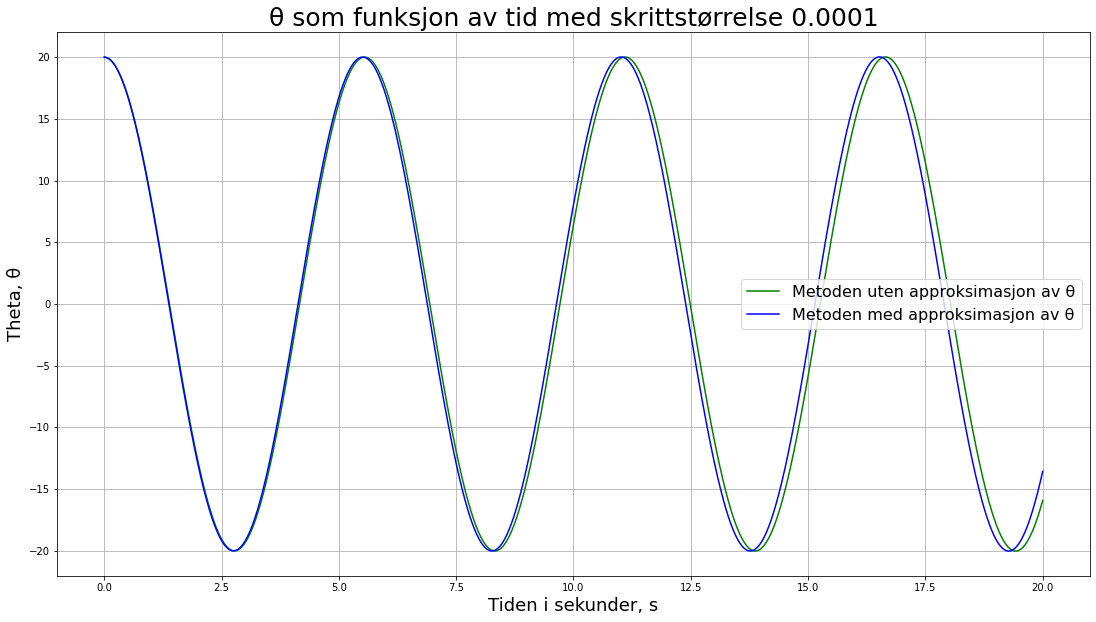

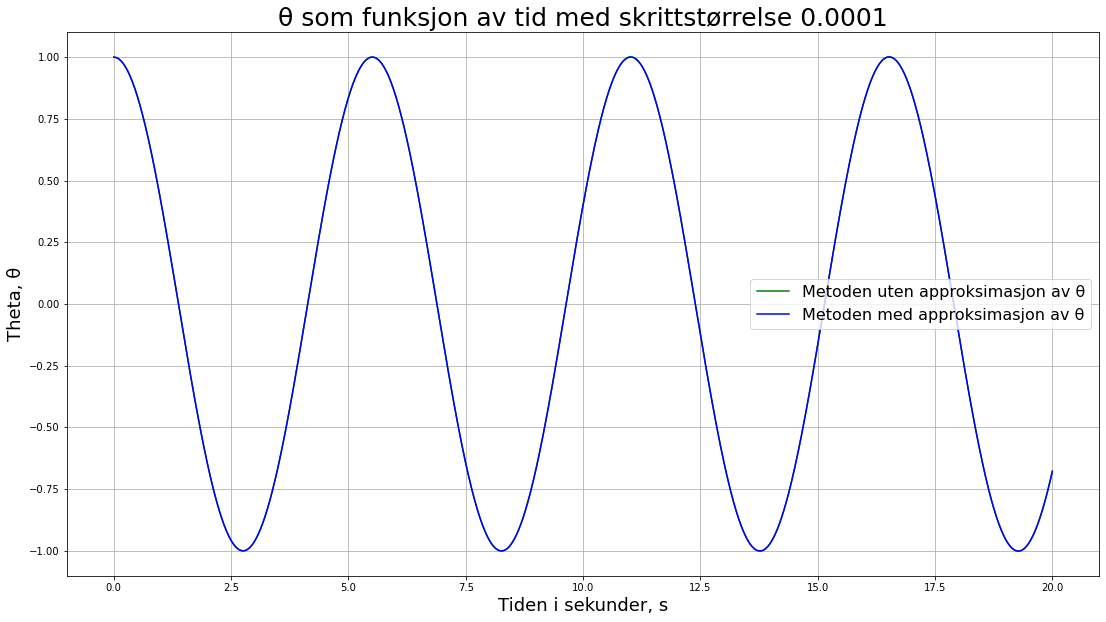

In [20]:
# Oppgave 1e
# Finne løsning numerisk 
def fVec2(t, w):      #Likning (10) løst for dw/dt = f(t, w). Med småvinkeltilnærming
    return np.array([w[1], -m*g*h*w[0]/Ic]) 

#Ny plottefunksjon
def plotThetaSammen(t1, w1, t2, w2, theta0): #Plotter to grafer i sammen for sammenligning
    theta1 = hentTheta(w1)
    theta2 = hentTheta(w2)

    plt.figure()
    plt.plot(t1, theta1, label='Metoden uten approksimasjon av \u03B8', color = 'g')
    plt.plot(t2, theta2, label='Metoden med approksimasjon av \u03B8', color = 'b')
    plt.grid()
    plt.title(f'\u03B8 som funksjon av tid med skrittstørrelse {dt}', fontsize=25)
    plt.xlabel('Tiden i sekunder, s', fontsize=18)
    plt.ylabel('Theta, \u03B8', fontsize=18)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10)
    plt.legend()
    plt.show()
    
w1 = np.array([degToRad(20), 0])     #To-dimensjonal array [theta(0), w(0)]
w2 = np.array([degToRad(1), 0])   #To-dimensjonal array [theta(0), w(0)]

tArr1, wArr1 = ode_solver(fVec, t0, tend, w1, dt, method=euler)   #Henter 2 to-dimensjonale arrays med verdier
tArr11, wArr11 = ode_solver(fVec, t0, tend, w2, dt, method=euler)
tArr2, wArr2 = ode_solver(fVec2, t0, tend, w1, dt, method=euler)
tArr22, wArr22 = ode_solver(fVec2, t0, tend, w2, dt, method=euler)

plotThetaSammen(tArr1, wArr1, tArr2, wArr2, w1[0]) #Plotter for startvinkel 20 grader
plotThetaSammen(tArr11, wArr11, tArr22, wArr22, w2[0]) #Plotter for startvinkel 1 grad


Vi ser at approksimasjonen for 1 grad er veldig god, ettersom de to løsningene er helt like. Sammenligner vi vinklene ved 20 grader ser vi at løsningen med approksimasjon vil gi et lite feilledd, og den avviker mer og mer fra løsningen uten approksimasjon av vinkel. Dette gir mening, ettersom vi bare burde bruke approksimasjonen for små vinkelutslag. 


### Runge Kutta Metode (RK4)
#### Oppgave 1f


Videre nå skal vi se på en høyere ordens metode. Vi implementerer RK4 metoden. Dette er en fjerde ordens Runge Kutta metode, sammenlignet med Euler som er en første ordens Runge Kutta metode. At det er en fjerdeordens metode vil si at feilen er proporsjonal med $C\cdot (dt)^4$. Her tar vi med de fire første leddene i taylorrekke utviklingen, slik at det første feilleddet er proposjonal med nettopp $(dt)^4$. 
Begge metodene er eksplisitte, som vil si at vi kan gjøre beregningene direkte ved hjelp av kjente størrelser. På denne måten bruker vi funksjonsevalueringer i tidligere tidssteg for å regne ut den nye verdien, uten å ta i betraktning fremtidige tidssteg og koblede sett av ligninger (implisitt). RK4 er  er relativt enkel å implementere, til tross for at den er fjedeordens. Vi kan fremdeles bruke den samme ODE_solveren, men må bytte ut metoden. 


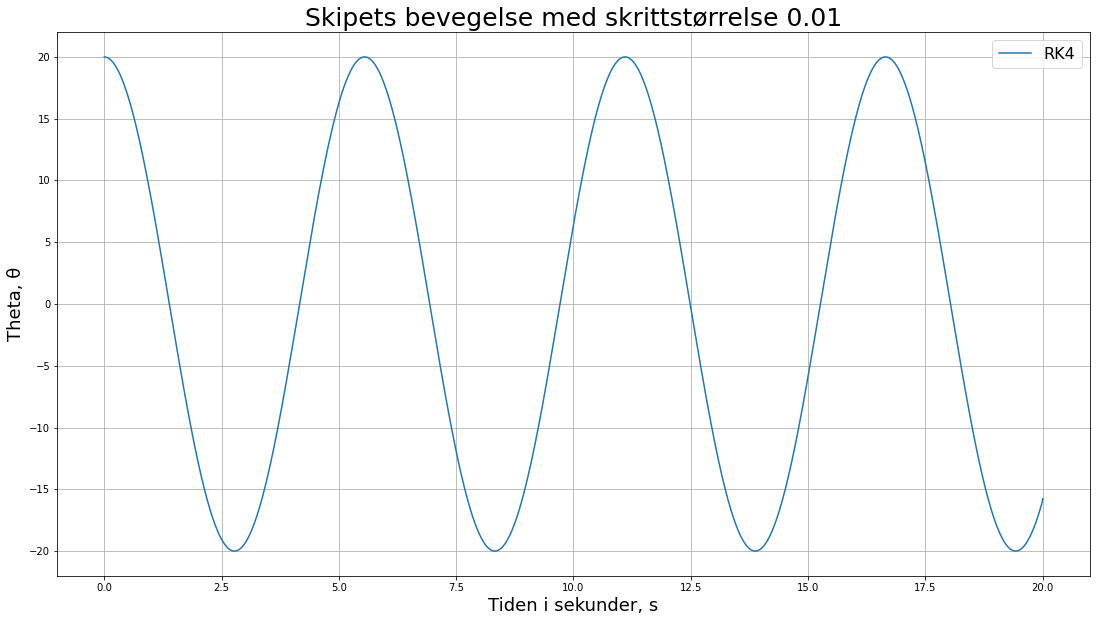

Med steglengde 0,01 tok det 0.06 sekunder


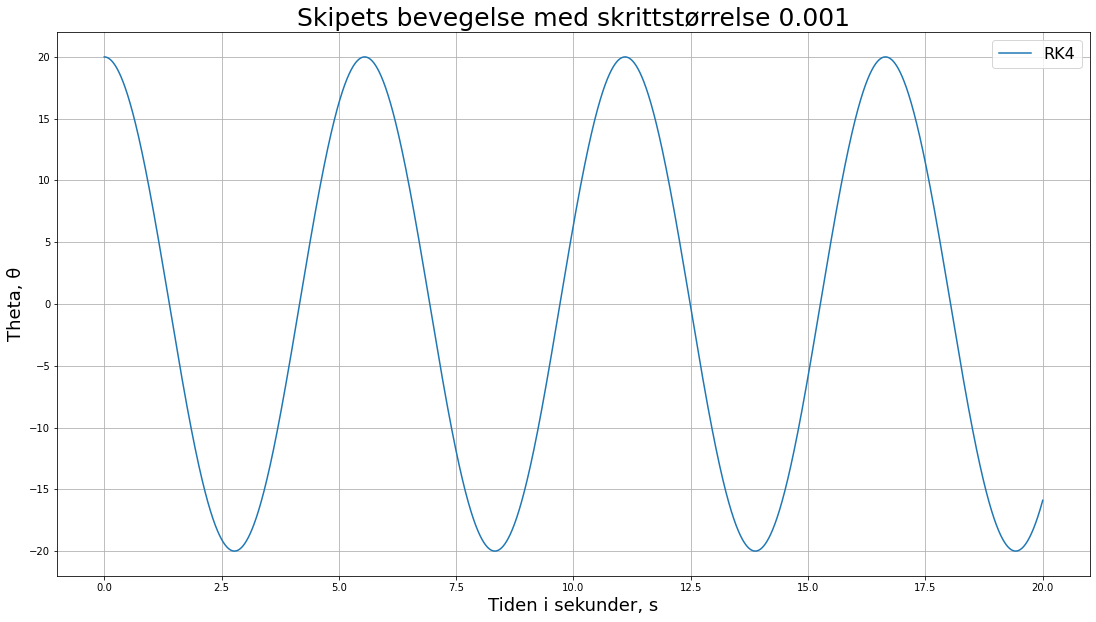

Med steglengde 0,001 tok det 0.74 sekunder


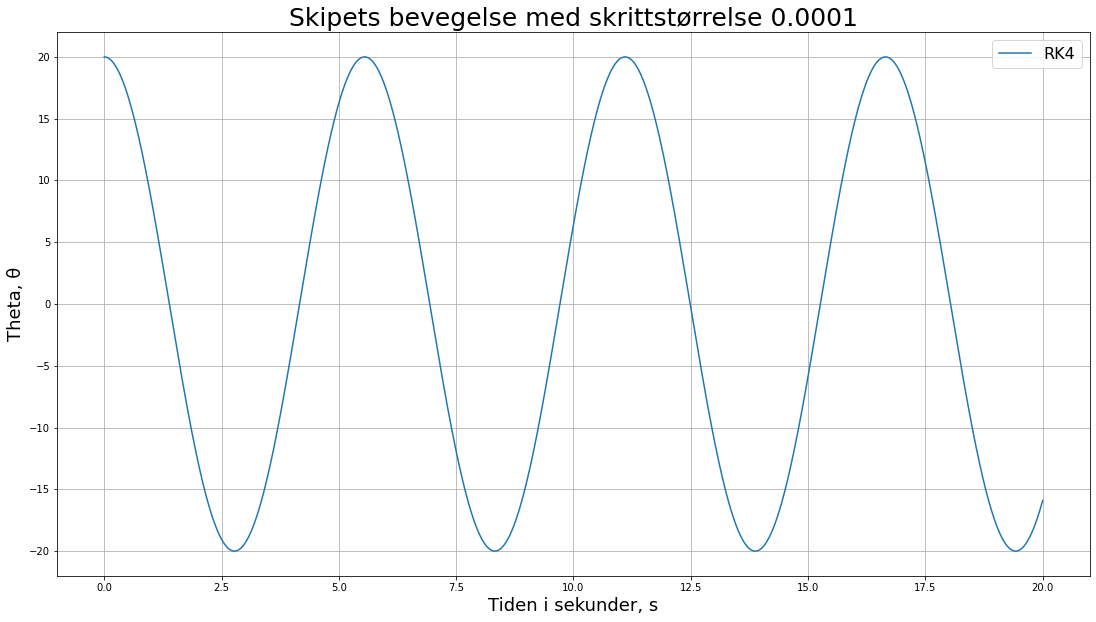

Med steglengde 0,0001 tok det 21.73 sekunder


In [23]:
#Oppgave 1f - Runge Kutta

def RK4(f, t, w, dt): #Implementerer Runge Kutta metoden 
    k1 = f(t, w)
    k2 = f(t +dt/2, w + dt*k1/2)
    k3 = f(t + dt/2, w + dt*k2/2)
    k4 = f(t + dt, w + dt*k3)

    w = w +dt/6*(k1 + 2*k2 + 2*k3 + k4)
    t_next = t + dt
    return t_next, w



t1 = time.time()
tArr001, wArr001 = ode_solver(fVec, t0, tend, w0, 0.01, method=RK4) 
t2 = time.time()
t3 = time.time()
tArr0001, wArr0001 = ode_solver(fVec, t0, tend, w0, 0.001, method=RK4) 
t4 = time.time()
t5 = time.time()
tArr00001, wArr00001 = ode_solver(fVec, t0, tend, w0, 0.0001, method=RK4) 
t6 = time.time()
plotTheta(tArr001, wArr001, "RK4", 0.01)
print("Med steglengde 0,01 tok det {:.2f}".format(t2-t1), 'sekunder')
plotTheta(tArr0001, wArr0001, "RK4", 0.001)
print("Med steglengde 0,001 tok det {:.2f}".format(t4-t3), 'sekunder')
plotTheta(tArr00001, wArr00001, "RK4", 0.0001)
print("Med steglengde 0,0001 tok det {:.2f}".format(t6-t5), 'sekunder')

Som vi ser gir RK4 veldig mye bedre resultater enn Euler, særlig for dt = 0,01. Den bruker derimot litt mer tid, men det er fordi den må gjøre fire funksjonsevalueringer per iterasjon, i motsetning til euler som bare gjør én. Videre nå ønsker vi å sammenligne disse to metodene litt mer, og se på hvor stor feilen er for ulike verdier av dt. 

### Analytisk løsning
#### Oppgave 1g

For å kunne sammenligne RK4 og Euler må vi finne den analytiske løsningen. Dermed kan vi se på forskjellen mellom de numeriske løsnignene og den faktisk løsningen på differensialligningen. 

Finner den analytiske løsningen av differensiallikningen (10). Bruker fortsatt småvinkeltilnærming.
 
$$-mgh\theta = I_C\ddot{\theta}$$<br>
$$I_C\ddot{\theta} + mgh\theta = 0 $$
 
$$\ddot{\theta} + \frac{mgh}{I_C}\theta = 0 $$
 
som gir den karakteristiske likningen
$$\lambda^2 + k = 0$$ der $$k = \frac{mgh}{I_C}$$
 
som gir løsning
$$\lambda = \pm \sqrt(-\frac{mgh}{I_c}) = \pm \sqrt(-1) \cdot \sqrt(\frac{mgh}{I_c}) = \pm i \cdot \sqrt(\frac{mgh}{I_c}$$
 
Vi har altså to komplekse løsnigner, og bruker den generelle løsningen:
 
$$\tilde{\theta}(t) = K_1 \cdot cos(at) + K_2 \cdot sin(at) ,\quad a = \sqrt{\frac{mgh}{I_c}}$$
Initialbetingelsene:
$$\quad\tilde{\theta}_0 = \theta_0 ,\quad \tilde{w}_0 = 0 $$
$$\tilde{\theta}(0) = K_1 \cdot cos(0) + K_2 \cdot sin(0) = 0 $$<br>
$$K_1= \theta_0 $$
<br>
$$\tilde{w}(0) = -aK_1 \cdot sin(0) + aK_2 \cdot cos(0) =0$$ <br>
$$K_2 = 0$$
Dette gir løsningen <br>
$$\tilde{\theta}(t) = \theta_0 \cdot cos(\sqrt{\frac{mgh}{I_c}}t)$$


### Sammenligning RK4 og Euler
#### Oppgave 1h

Nå som vi har den analytiske løsningen kan vi sammenligne metodene. Vi setter $\theta_0=0.01$ ettersom den analytiske er løst for små vinkler, må vi bruke en relativt liten vinkel. Som gjort i utregningen setter vi $\omega_0 = 0$. Vi finner absoluttverdien av differansen mellom den analytiske og de numeriske løsningene ved t=20 sekunder. Dette gjør vi for mange ulike dt, slik at vi kan plotte feilene. 

For at den siste kjøringen i solveren skal være for nøyaktig 20s, er vi nødt til å justere koden vår. Vi legger inn if-setningen i bunnen av ODE_solver: 

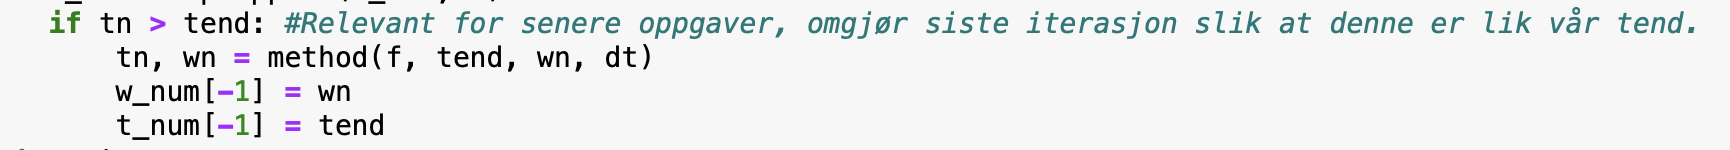

som gjør at dersom tidsverdien vi har kjørt for vår siste iterasjon er større enn tend, kjører vi den siste iterasjonen på nytt med t = tend, og erstatter de siste verdiene vi har i $\vec{w}$ og t_array. 

I ettertid har vi sett at kodene som vi har hentet fra notatene løser dette problemet med denne if-setningen:

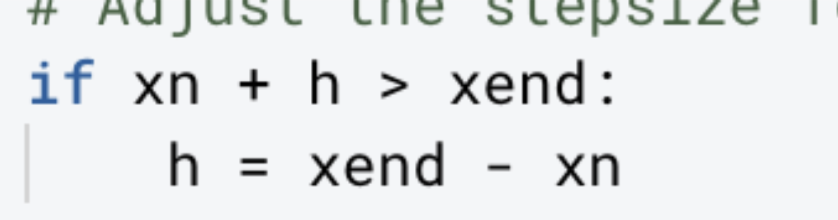

Denne metoden er bittelitt mer effektiv, da man løser problemet før det oppstår, i motsetning til vår metode som endrer løsningen etter at problemet har inntruffet. Allikevel har vi ikke sett det som nødvendig å endre koden vår, da det kun gjelder den siste iterasjonen, og det kun ville spart ekstremt kort kjøretid. 

Dette gjør at den siste steglengden ikke vil være lik som de foregående, men siden steglengdene er svært små i utgangspunktet vil det ikke ha noen praktisk betydning for løsningen vår. Siden vi gjør dette for begge metodene vil vi uansett få et godt sammenligningsgrunnlag. Dette gjør vi slik at vi kan finne den analytiske løsningen for nøyaktig 20s, før vi sammenlikner. 


In [38]:
#Oppgave 1h

dt0 = 0.0001 #den minste dt vi vil se på 
dtend = 0.1 #største verdi for dt
w01h = np.array([0.01, 0]) #startsbetingelser

def fAnalytisk(t, theta0): #Henter ut den analytiske løsningen
    return theta0*np.cos(np.sqrt((m*g*h/Ic))*t)

#Funksjon for differansen
def differanse(dt0, dtend, w, f, n, t0, tend, theta0):
    dt = np.linspace(dt0, dtend, n) #liste med verdiene for dt vi skal sjekke
    forskjellerE = np.zeros(len(dt)) #Tom array som vi fyller med differansen mellom analytisk og numerisk Euler
    forskjellerRK = np.zeros(len(dt)) #Tom array som vi fyller med differansen mellom analytisk og numerisk Runge Kutta
    thetaAn = fAnalytisk(tend, theta0) #henter ut den analytiske theta ved tend
    for i in range(len(dt)): 
        tE, wE = ode_solver(f, t0, tend, w, dt[i], method=euler)
        tRK, wRK = ode_solver(f, t0, tend, w, dt[i], method=RK4)
        forskjellE = abs(radToDeg(thetaAn) - hentTheta(wE)[-1]) #Henter ut den siste theta (ved tend)
        forskjellRK = abs(radToDeg(thetaAn) - hentTheta(wRK)[-1])
        forskjellerE[i] = forskjellE
        forskjellerRK[i] = forskjellRK
    return dt, forskjellerE, forskjellerRK
dtArr, forskjellerE, forskjellerRK = differanse(dt0, dtend, w01h, fVec2, 10000, t0, tend, 0.01)

#Plottefunksjon
def plotteForskjellerLog(dt, forskjellerE, forskjellerRK):
    plt.figure()
    plt.plot(dt, forskjellerE, label='Forskjeller mellom analytisk og Euler')  #Plotter numerisk løsning
    plt.plot(dt, (forskjellerRK), label='Forskjeller mellom analytisk og Runge Kutta') 
    plt.grid()
    plt.title(f'Differansen plottet med logaritmiske akser', fontsize = 25)
    plt.xlabel('Tidssteg, dt', fontsize = 18)
    plt.ylabel('Forskjellen i \u03B8 ved 20 sekunder', fontsize = 18)
    plt.yscale('log') 
    plt.xscale('log') 
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10)
    plt.legend()
    plt.show()
    
def plotteForskjeller(dt, forskjellerE, forskjellerRK):
    plt.figure()
    plt.plot(dt, forskjellerE, label='Forskjeller mellom analytisk og Euler')  #Plotter numerisk løsning
    plt.plot(dt, (forskjellerRK), label='Forskjeller mellom analytisk og Runge Kutta') 
    plt.grid()
    plt.title(f'Differansen mellom de numeriske metodene og den analytiske', fontsize = 25)
    plt.xlabel('Tidssteg, dt', fontsize = 18)
    plt.ylabel('Forskjellen i \u03B8 ved 20 sekunder', fontsize = 18)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10)
    plt.legend()
    plt.show()


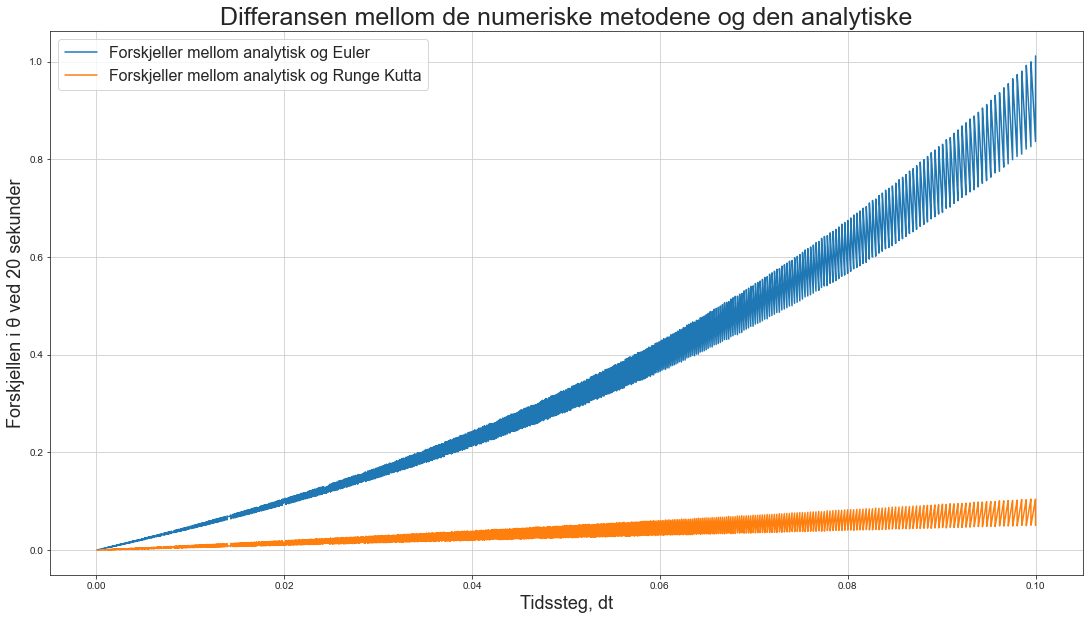

In [39]:
plotteForskjeller(dtArr, forskjellerE, forskjellerRK)

Det er tydelig at feilen er mindre for kortere tidssteg, og øker for lengre tidssteg, noe som var forventet. Vi ser at Euler-metoden gir mye større feil enn RK4-metoden, og at forskjellen blir større etter hvert som tidsstegene øker. Dette stemmer overens med at Euler-metoden er av første orden, mens RK4 er av 4. orden. 
Feilen til en numerisk metode av orden n, og steglengde dt, er gitt ved: 

$$E(dt) \leq C\cdot (dt)^n$$

Hvor C er en konstant som er uavhengig av dt. 
Dermed ser vi at for små dt vil ikke potensen spille like stor rolle, ettersom feilen er svært liten uansett. For RK4 metoden ser det nesten ut som feilen flater helt ut for små dt, og det er fordi et lite tall opphøyes i fire, og da blir det svært lite. Men når dt etter hvert øker, ser vi at det blir stor forskjell på en førsteordens løsning og en fjerdeordens løsning. Feilen i Euler metoden vil øke proposjonalt med dt, mens feilen i RK4 klarer å holde seg rimelig lav gjennom hele intervallet. Grunnen til at RK4 sin feil ikke ser ut som en fjerdepotensgraf er fordi vi ser på et såpass lite intervall at den ikke rekker å vokse seg stor. 

Det er også verdt å merke seg at vi har kjørt koden for ti tusen iterasjoner, og det er derfor grafene blir såpass tykk. 

Det kan være interessant å plotte feilen med logaritmisk skala.

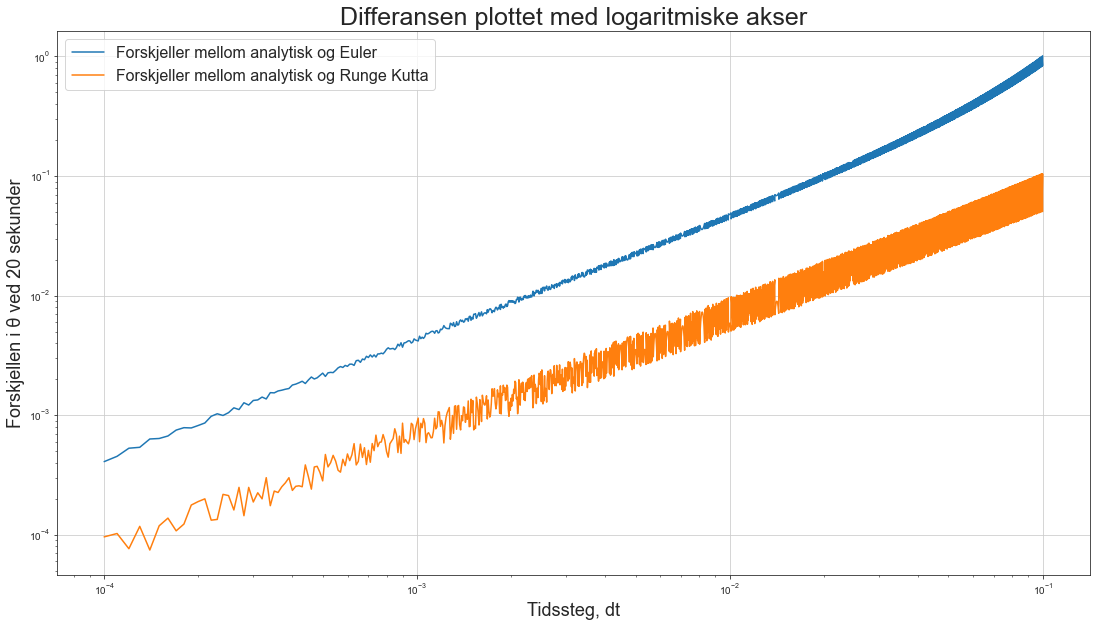

In [40]:
plotteForskjellerLog(dtArr, forskjellerE, forskjellerRK)

Med dette logaritmiske plottet får vi tydligere sett at også RK4 metoden sin feil vil øke med økt dt. Man ser også  den relative feilen for hver av metodene bedre. Når tidsstegene etter hvert blir større har vi mange flere iterasjoner på et kortere intervall. Det ser vi ved at tettheten øker der. Men det er tydelig at for små dt-verdier vil feilen "hoppe" litt opp og ned. Nå vil vi finne stigningstallet også. 

a = 8.920737021038917 +/- 0.017903785717514255
b = -0.08892479661015829 +/- 0.0010342185671541092
a = 0.7775530356021242 +/- 0.003087207959431098
b = -0.000959604821194393 +/- 0.00017833365213670556


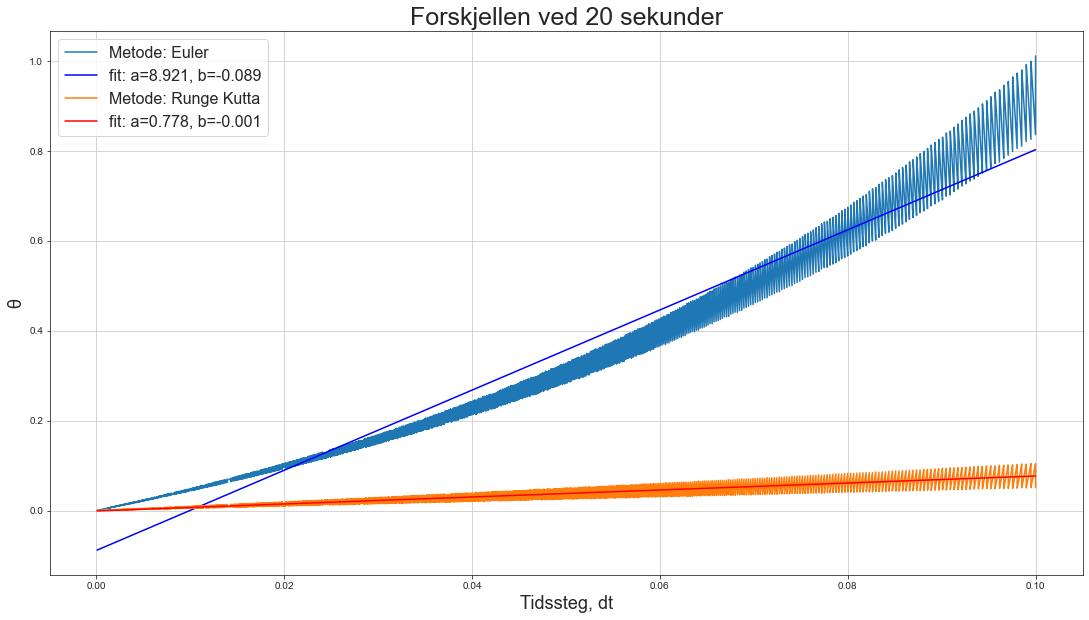

In [263]:
#Her plotter vi differansen mellom siste theta-verdi ved Eulers Metode og Runge Kutta mot 
#analytisk løsning, sammen med en kurvetilpasning. Dette er for å vise stigningstallet. 

def line(x, a, b):    #Tar utgangspunkt i at feilen øker lineært
    return (a*x + b)

poptE, pcovE = curve_fit(line, (dtArr), (forskjellerE))  #Henter stigningstall a og b i popt
poptRK, pcovRK = curve_fit(line, (dtArr), (forskjellerRK))


print("a =", poptE[0], "+/-", pcovE[0,0]**0.5)  
print("b =", poptE[1], "+/-", pcovE[1,1]**0.5)

print("a =", poptRK[0], "+/-", pcovRK[0,0]**0.5)
print("b =", poptRK[1], "+/-", pcovRK[1,1]**0.5)

fEuler = line(dtArr, poptE[0], poptE[1])
fRK = line(dtArr, poptRK[0], poptRK[1])

sns.set_style('ticks') 
plt.figure()
plt.grid()
plt.plot(dtArr, forskjellerE, label = 'Metode: Euler')
plt.plot(dtArr, fEuler, 'b-', label='fit: a=%5.3f, b=%5.3f' % tuple(poptE))  #Plotter kurvetilpasset
plt.plot(dtArr, forskjellerRK, label = 'Metode: Runge Kutta')
plt.plot(dtArr, fRK, 'r-', label='fit: a=%5.3f, b=%5.3f' % tuple(poptRK))
plt.title('Forskjellen ved 20 sekunder', fontsize = 25)
plt.xlabel('Tidssteg, dt', fontsize = 18)
plt.ylabel('\u03B8', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10)
plt.legend()
plt.show()


I plottet her har vi plottet løsningene sammen med en kurvetilpasning. Her finner vi stigningstallet for feilen til de ulike metodene. 

Vi ser at Euler metoden kan approksimeres til at feil som funksjon av tid er 

Error_Euler(steglengde) = 8.9*steglengde (øker ikke helt lineært)

Error_RK4(steglengde) = 0.8 *steglengde (øker lineært)

Vi hadde forventet at Euler metoden sine feilene skulle øke lineært ettersom feilleddet er proposjonalt med dt. Dette er altså noe uforventet, men kan skyldes approksimasjonen vi gjorde i ODE_solver for å finne verdien til nøyaktig t=20. Når vi har såpass store steglengder som 0,1 vil "trikset" vi gjorde (med if-setningen i ODE_solver) kunne ha større påvirkning enn ønsket. Det skal også nevnes at en steglengde på 0,1 er helt urealistisk å bruke med Euler metoden uansett, ettersom steget er alt for stort, og vil gjøre Euler metoden veldig uegnet for å løse slike problemer. Dersom vi derimot fokuserer på steglengdene fra 0 til 0.01 i plottene ser vi at Euler er tilnærmet lineær slik som var å forvente. 

# Oppgave 2


Videre skal vi fremdeles se på det samme systemet, men bruker i resten av oppgavene bare RK4-metoden. Hittil har skipet hatt en konstant mengde fortrengt vann, noe som er en veldig forenklet modell i forhold til virkeligheten. For å gjøre den litt mer realistisk skal vi nå ta hensyn til at mengden fortrengt vann vil variere. På denne måten vil posisjonen til massesenteret bevege seg. Dette må vi ta hensyn til ettersom vi hittil har antatt at det er i ro. Vi vil også nå se på hvordan friksjon, vind og bølger spiller inn for å gjøre det enda mer realistisk. Dessuten skal vi studere båtens dynamikk når den får en last på dekket. Vi vil implementere ting litt etter litt, og starter relativt enkelt. 


I koden under her har vi laget en ny ode_solver som tar inn nye parametere som blant annet "gjerde" og "last". Vi prøvde å lage den mest mulig generell slik at den kan brukes til å løse ulike typer problemer. De forskjellige parametrene vil bli ordentlig introdusert i senere oppgaver hvor det er relevant. Vi valgte å legge koden øverst her i oppgave 2 slik at den kan brukes videre i alle oppgavene videre. Vi har også laget en ny RK4 metode, hvor eneste forskjellen er at den tar inn en ekstra paramterer $m_L$, som er massen til lasten. Denne vil bli nyttig ettersom de nye funksjonene er avhengig av å få inn $m_L$ som parameter. 

In [66]:
def rungeKuttaMetode2(f, t, w, dt, mL): 
    #Identisk runge kutta metode 1, men tar inn ekstra argument mL, da dette brukes i f videre
    k1  = f(t, w, mL)
    k2 = f(t +dt/2, w + dt*k1/2, mL)
    k3 = f(t + dt/2, w + dt*k2/2, mL)
    k4 = f(t + dt, w + dt*k3, mL)

    w = w +dt/6*(k1 + 2*k2 + 2*k3 + k4)
    t_next = t + dt
    return t_next, w

def ode_solverGjerde(f, t0, tend, warr, dt, mL, last = False, gjerde = True, method=rungeKuttaMetode2):
    #Ny ode solver som tar hensyn til last og gjerde
    #Initializing:
    w_num = np.array([warr])    # Array for the solution y 
    t_num = np.array([t0])    # Array for the x-values

    tn = t0                # Running values for x and y
    wn = warr 

    lastFaltAv = False #sjekker om lasten er falt av (uten gjerder)

    while tn < tend:# - 1.e-10: 
         # Buffer for truncation errors    
        tn, wn = method(f, tn, wn, dt, mL)    # Do one step by the method of choice
        if lastFaltAv: #om last har falt av må oppdatere wn[6] hver gang siden den endrer seg i metoden
            if wn[6] < 0:
                wn[6] = -2*R #Massens posisjon settes til 2*R for å få den unna båten
            if wn[6] > 0: 
                wn[6] = 2*R

        #Oppgave 2d og e: 
        if last: #Hvis vi har last
            if abs(wn[6])>=R and abs(wn[6])<2*R: #Dersom lasten når kanten av skipet
                if gjerde:  #Ulik håndtering av lasten hvis det er gjerde eller ikke. 
                    if wn[6] < 0: 
                        wn[6] = -R #Lasten forblir på ytterkanten
                        wn[7] = 0 #Farten nullstilles
                    if wn[6] > 0:
                        wn[6] = R
                        wn[7] = 0
                else:  #lasten flyr av
                    lastFaltAv = True
                    mL = 0 #Massen nullstilles og skal ikke påvirke skipets dynamikk
        
        
        #Oppgave 2c: 
        #Vil se om båten kantrer: 
        dYc = wn[2]-yC0   #Finner dYc 
        gamma = 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(wn[0]))+dYc/R) #Finner gamma
        kanteKrav = (np.pi- gamma)/2 #Ved denne verien kantrer skipet
        if wn[0] > kanteKrav:
            if wn[0] > 0: #Kantrer med klokken (Tippe til høyre)
                fortegn = 1
            else: 
                fortegn = -1
            while tn < tend: #Fullfører vektoren
                wNye = np.zeros(len(wn)) #alle verdier settes til null
                wNye[0] = np.pi/2*fortegn #Theta får lik verdi for resten av w
                w_num = np.concatenate((w_num, (np.array([wNye])))) #slår sammen arrays
                t_num = np.append(t_num,tn)
                tn += dt
            return t_num, w_num
        
        w_num = np.concatenate((w_num, (np.array([wn]))))
        t_num = np.append(t_num,tn)
        if tn > tend: #Relevant for oppgave 1h, omgjør siste iterasjon slik at denne er lik vår tend. 
            tn, wn = method(f, tend, wn, dt, mL)  
            w_num[-1] = wn
            t_num[-1] = tend      
            
    return t_num, w_num #Returnerer tidene og w





### Seksdimensjonal $\vec{f}$
#### Oppgave 2a

Vi utvider $\vec{f}$ til å være seksdimensjonal. I tillegg til $\theta$ og $\omega$, skal den også inneholde både posisjonen og hastigheten til massesenteret (oppgitt i x- og y-retning). Vi legger altså til $Y_C$,  $v_{Y_C}$, $X_C$, $v_{X_C}$, som er henholdsvis y-koordinaten til massesenteret, farten til massesenteret i y-retning, x-koordinaten til massesenteret, farten til massesenteret i x-retning. 

I første omgang tar vi bare hensyn til kreftene som virker i y-retning, altså gravitasjonskraften (14a) og oppdriftskraften (14b) fra vannet. Det vil altså fremdeles bare være oppdriftskraften som gir et bidrag til dreiemomemntet (15a). Det eneste som har endret seg fra oppgave 1 er at arealet fortrengt vann kan variere. Dermed kan vi sette $X_C = 0$ og $v_{X_C} = 0$ foreløpig. 

Finner den nye $\vec{f}$: 
 
 
Setter nå $\vec{w}(t) = [\theta (t), \omega(t), y_C, v_{y_C}, x_C, v_{x_C}]^T$
<br>der $\omega = \frac{d\theta}{dt}, v_{y_C} = \frac{dy_C}{dt}, v_{x_C} = \frac{dx_C}{dt}$
<br>
Finner ny
$\vec{f} = \frac{d\vec{w}(t)}{dt}$ <br>
Vi deriverer $\vec{w}(t)$ <br>
$\frac{d\vec{w}}{dt} = [\frac{d\theta}{dt}, \frac{d\omega}{dt}, \frac{dy_C}{dt}, \frac{dv_{y_C}}{dt}, \frac{dx_C}{dt}, \frac{dv_{x_C}}{dt}]^T $
 
$\frac{d\vec{w}}{dt} = [w(t), \frac{-F_Bhsin(\theta)}{I_C}, v_{y_C}, \frac{g(A\sigma_0-m)}{m}, 0, 0]^T $
 
som gir 
$\vec{f} = [\vec{w}[1], \frac{-F_Bhsin(\vec{w}[0])}{I_C}, \vec{w}[3], \frac{g(A\sigma_0-m)}{m}, 0, 0]^T$

### Effekten av variasjonen av mengden fortrengt vann
#### Oppgave 2b

Vi ønsker nå å bruke $\vec{f}$ til å løse ODE-ligning (13) numerisk med RK4. Vi bruker initialverdiene $\theta_0 = 20^{\circ} $ og $\omega_0 = 0$. Dette gjorde vi tilsvarende i oppgave 1, men der brukte vi eulers metode, i tillegg til at vi ikke tok hensyn til at arealet fortrengt vann endrer seg.

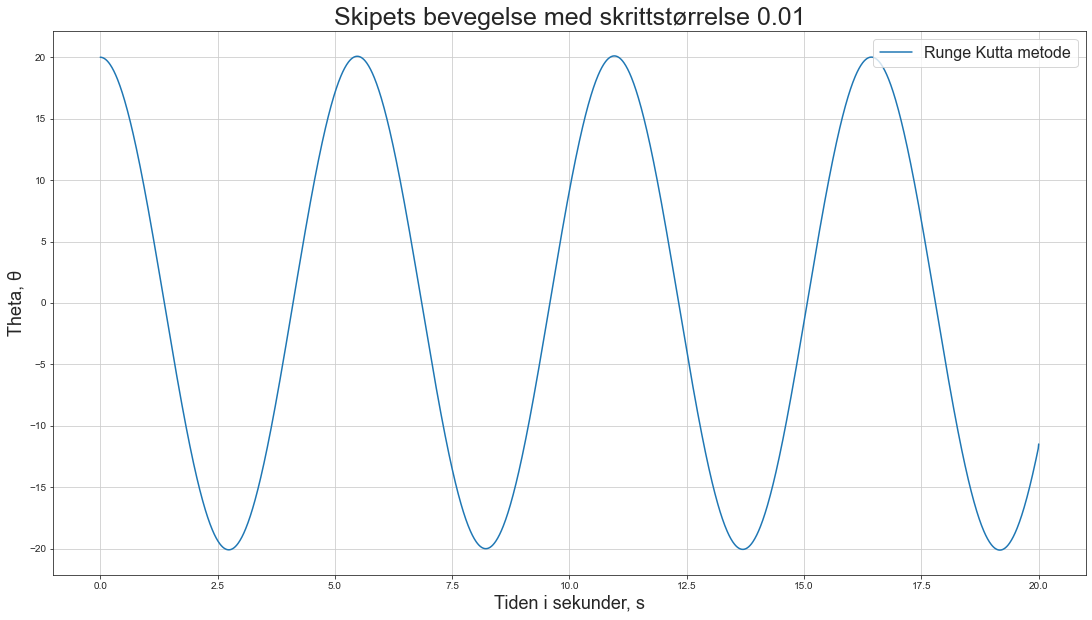

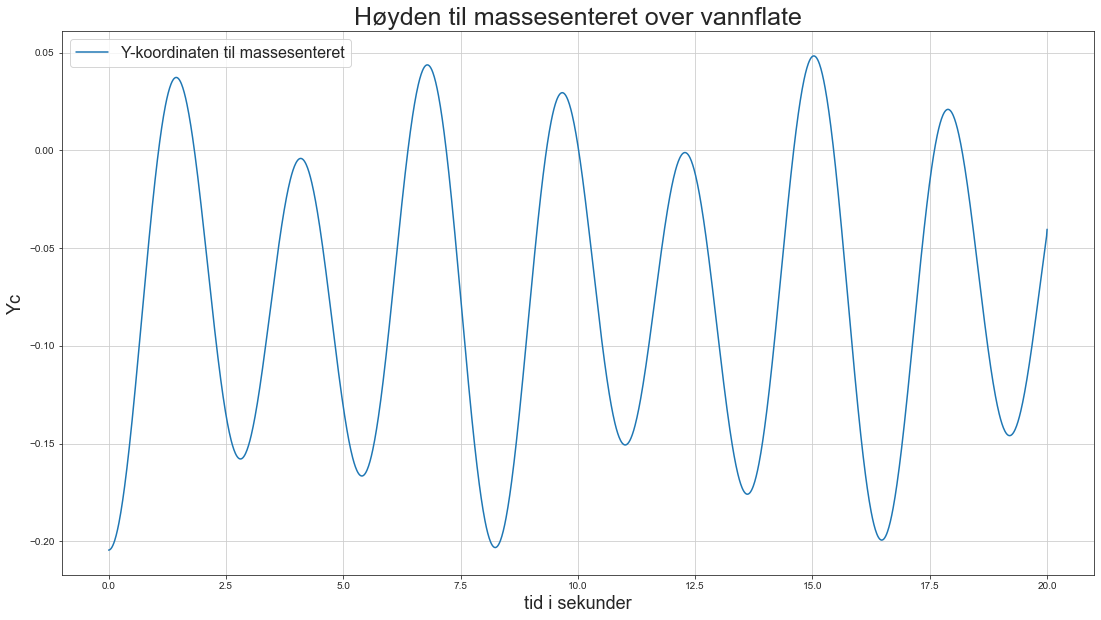

In [67]:
#Oppgave 2b
#w = [theta, w, yc, vy, xc, vx]  

def fvecny(t, w, mL):
    dYc = w[2]-yC0
    gamma = 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(w[0]))+dYc/R)
    A = 1/2*R**2*(gamma-np.sin(gamma))
    Fb = A*sigma0*g
    arr = np.array([w[1], -Fb*h*np.sin(w[0])/Ic, w[3], g*(A*sigma0-m)/m,0, 0])
    return arr


w0_2 = np.array([degToRad(20), 0.0, yC0, 0.0, 0.0, 0.0])   #w0 vektor
dt = 0.01   #steglengde

tArr_2, wArr_2 = ode_solverGjerde(fvecny, t0, tend, w0_2, dt, 0, method=rungeKuttaMetode2) #Løser diffligningen
plotTheta(tArr_2, wArr_2, "Runge Kutta metode", dt)

#Hjelpefunksjon:
def hentUt(w, indeks):  #kan hente ut forskjellige lister ut i fra hva som trengs (indeksering)
    arr = np.zeros(len(w)) 
    for i in range(len(w)):
            arr[i] = w[i][indeks] #finner akkurat det vi vil se på 
    return arr

#Plottefunksjon
def plottYc(tarr, warr):
    yc_arr = hentUt(warr, 2)
    plt.figure()
    plt.grid()
    plt.plot(tarr, yc_arr, label = "Y-koordinaten til massesenteret")
    plt.title("Høyden til massesenteret over vannflate", fontsize = 25)
    plt.xlabel("tid i sekunder", fontsize = 18)
    plt.ylabel("Yc", fontsize = 18)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10)
    plt.legend()
    plt.show()


plottYc(tArr_2, wArr_2)

Sammenligner vi plottet for $\theta$ med tilsvarende fra oppgave 1d, ser vi at de er svært like. Dette tyder på at forenklingen vi gjorde i oppgave 1, med å si at mengden fortrengt vann var konstant, har hatt lite innvirkning på resultatet.

Videre plottet vi $y_c$ som funksjon av tiden. Som vi kan se vil det være periodiske variasjoner i maksimalverdien til absoluttverdien av yc. Dette kan skyldes at når skipet dupper langt ned i vannet, vil mengden fortrengt vann være stor og oppdriftskraften tilsvarende. På denne måten får skipet en stor akselerasjon oppover, og $y_c$ havner høyt over vannoverflaten. Da har båten fortrengt lite vann, og oppdriftskraften er betydelig mindre. Når den faller ned igjen vil noe av vannet være med på å dempe bevegelsen, og skipet dupper ikke like langt ned. Når den igjen får nok fart til å duppe lengre ned, vil prosessen gjenta seg selv. 

### Kantring av skipet
#### Oppgave 2c

Om dekket kommer i kontakt med vann, altså om $\theta$ blir stor nok, vil skipet kantre. Vi skal videre utvide koden vår til å ta hensyn til dette. Når skipet kantrer skal alle komponentene av $\vec{w}$ settes lik null, bortsett fra $\theta$ som settes lik $\pm \frac{\pi}{2}$(alt etter hvilken vei den kantrer). Kriteriet for kantring er: 

$\theta > \frac{\pi - \gamma}{2}$

Måten vi løser dette problemet på er å sjekke om båten kantrer inni ode_solveren. Dermed kan vi sjekke for hver iterasjon om $\theta$ oppfyller kantringskravet ovenfor. Hvis dette er tilfellet sender vi verdiene gjennom en while-løkken som itererer seg gjennom resten av tidspunktene, og sører for at verdiene blir nullstilte slik som beskrevet ovenfor. Deretter returneres $\vec{w}$ og funksjonen avsluttes. 

Her er et bilde av hvordan det blir løst inni ode_solveren: 

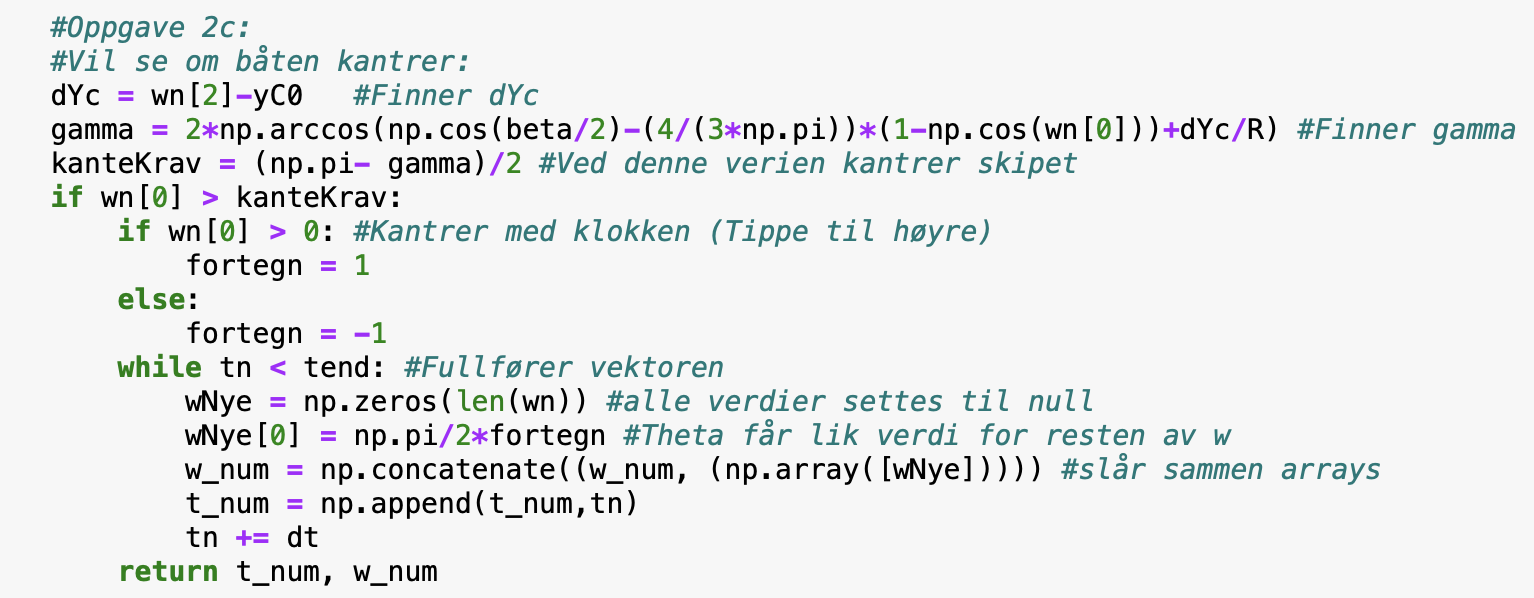

Vi ser altså at om båten kantrer nullstiller de fleste verdiene seg, slik at båten flyttes tilbake til utgangsposisjonen. Dette er bare for å gjøre det enkelt å se at båten har kantret. Intuitivt gir det muligens mer mening om massesenteret hadde beholdt koordinatene sine fra når båten kantrer, men vi legger oss ikke opp i dette. 

Dersom $\theta_0 = 0$, hva er den laveste verdien for $\omega_0$ som gir kantring?

In [65]:
w0_vec = np.linspace(0,1,1000) #liste over verdier for w vi kan teste for
lavesteW = 0
for i in range(len(w0_vec)): #itererer gjennom lista
    w0_2c = np.array([0, w0_vec[i], yC0, 0, 0, 0]) #startsbetingelser ved ulike w0
    tArr_2c, wArr_2c = ode_solverGjerde(fvecny, t0, tend, w0_2c, dt, 0, method=rungeKuttaMetode2) # løser med nye startsbetingelser hver runde
    if abs(wArr_2c[-1][0]) == np.pi/2: #sjekker siste element for å se om skipet har kantret
        lavesteW = w0_vec[i] #lagrer minste verdi for w0 som gir kantring
        break #avslutter løkka
print("Laveste verdi som gir kantring: {:.2f}".format(lavesteW))


Laveste verdi som gir kantring: 0.43


Vi ser at den minste verdien for $\omega_0$ som gir kantring er $\omega_0 = 0.43$, gitt at skipet ikke har noe vinkelutslag fra starten av. Den må altså ha en viss vinkelhastighet for å kunne klare å kantre. Det skal merkes at vi bare sjekker om skipet kantrer i løpet av de første 20 sekundene, og at om vi hadde justert opp denne tiden kunne vi muligens klart oss med en mindre verdi for $\omega_0$.

### Last
#### Oppgave 2d

I denne oppgaven utvider vi koden vår til å inkludere båtens frie last. Vi bruker samme metode som i oppgave 2a, men nå utvider vi $\vec{w}$ til å også inkludere $s_L$ og $v_L$. Dette er henholdsvis posisjonen og hastigheten til lasten relativt båtens metasenter

Lastens dreiemoment: 

$\tau_L = -m_Lgcos(\theta)s_L \hspace{3cm} (15d)$

Summen av dreiemomentene kan nå beskrives av (15a) og (15d). 

Kraften fra Lasten: 

$F_L^x = m_Lgcos(\theta)sin(\theta) \hspace{0.5cm} (x) \hspace{1.4cm} (14f)$<br>
$F_L^y = -m_Lgcos^2(\theta) \hspace{0.5cm} (y) \hspace{2cm} (14e)$

Summen av kreftene som virker på båten kan beskrives av (14a), (14b), (14e) og (14f). 

Diffligning som beskriver lastens bevegelse: 

$m\ddot{\theta} = -mgsin(\theta)$<br>

Som gir: 

$\frac{dv_L}{dt} = -gsin(\theta)$

Den nye vektoren blir: 
 
$\vec{w}(t) = [\theta (t), \omega(t), y_C, v_{y_C}, x_C, v_{x_C}, s_L, v_L]^T$
<br>der $\omega = \frac{d\theta}{dt}, v_{y_C} = \frac{dy_C}{dt}, v_{x_C} = \frac{dx_C}{dt}, v_L = \frac{ds_L}{dt}$
<br>
Finner ny
$\vec{f} = \frac{d\vec{w}(t)}{dt}$ <br>
Vi deriverer $\vec{w}(t)$ <br>
$\frac{d\vec{w}}{dt} = [\frac{d\theta}{dt}, \frac{d\omega}{dt}, \frac{dy_C}{dt}, \frac{dv_{y_C}}{dt}, \frac{dx_C}{dt}, \frac{dv_{x_C}}{dt}, \frac{ds_L}{dt}, \frac{v_L}{dt}]^T $
 
$\frac{d\vec{w}}{dt} = [w(t), \frac{-F_Bhsin(\theta)-m_Lgcos(\theta)s_L}{I_C}, v_{y_C}, \frac{-(m+mL)g+A\sigma_0g-m_Lgcos(\theta)^2}{m+m_L}, v_{x_C}, \frac{m_Lgcos(\theta)sin(\theta)}{m + m_L}, v_L, -sin(\theta)g]^T $
 
som gir
$\vec{f} = [\vec{w}[1], \frac{-F_Bhsin(\vec{w}[0])-m_Lgcos(\vec{w}[0])\vec{w}[6]}{I_C}, \vec{w}[3], \frac{-(m+mL)g+A\sigma_0g-m_Lgcos(\vec{w}[0])^2}{m+m_L}, \vec{w}[5], \frac{m_Lcos(\vec{w}[0])sin(\vec{w}[0])}{m + m_L}, \vec{w}[7], -sin(\vec{w}[0])g]^T$

Vi må også redefinere likevektskonstantene. 
Vi setter $m_{Ny} = m + m_L$ som gir den nye massetettheten til båten $\sigma = \frac {m_{Ny}}{A_s}$. Med den nye verdien for $\sigma$ beregner vi $\beta_{ny}$ og nye likevektshøyder $y_M0, y_C0, y_B0, y_D$. 
Dette velger vi å gjøre inne i f-vektor, og for hver kjøring. Grunnen til at vi gjør det er for å ta hensyn til at lasten kan falle av, som gjør at båten vil få nye likevektsbetingelser. 


In [69]:
#Oppgave 2d
#w = np.array([theta, w, yc, vy, xc, vx, sL, vL]) 

#Hjelpefunksjon:
def finneYC0(mL):
    mNy0 = m + mL    #Ny masse til
    sigmaNy0 = mNy0/A_s #massetettheten til skipet per lengdeenhet (kg/m^2)
    betaNy0, nitNy = bisection(f, a, b, sigmaNy0, tol=1.e-6)
    yM0, yC0, yB0, yD0 = høyder(betaNy0)
    return yC0, betaNy0, mNy0


def fvecLast(t, w, mL): #ny fvec
    '''t: tiden
    w: w-array. 8 elementer. 
    mL: massen til lasten 
    returnerer: ny w-array'''
    
    yC0, betaNy, mNy = finneYC0(mL)
    dYc = w[2]-yC0
    gamma = 2*np.arccos(np.cos(betaNy/2)-(4/(3*np.pi))*(1-np.cos(w[0]))+dYc/R)   #Vinkelen for vannkontakt
    A = 1/2*R**2*(gamma-np.sin(gamma))  #Arealet til det fortrengte vannet
    Fb = A*sigma0*g

    #dw/dt-vektor = f:
    arr = np.array([w[1],(-Fb*h*np.sin(w[0])-mL*g*np.cos(w[0])*w[6])/Ic,    w[3],    (-mNy*g+A*sigma0*g-mL*g*(np.cos(w[0]))**2)/mNy,   w[5],    mL*g*np.cos(w[0])*np.sin(w[0])/mNy,    w[7], -np.sin(w[0])*g])   
    return arr   #np.array([w, dw/dt, vy, dvy/dt, vx, dvx/dt, vL, dvL/dt])


Dersom $\mid s_L \mid > R$ faller lasten av skipet, noe vi måtte ta hensyn til i ode_solver. I bildet under kan vi enn så lenge ignorere "gjerde"-delen av koden. Vi lagde en variabel med navn "lastFaltAv". Denne blir satt til "True" hvis vi oppdager at posisjonen til lasten er utenfor skipet. I tillegg settes massen til lasten lik null, slik at den ikke lengre påvirker skipets dynamikk. For hver iterasjon sjekker vi om "lastFaltAv" er "True" og i så fall oppdaterer vi posisjonen til lasten til å være $\pm$2R. Dette er en tilfeldigvalgt posisjon, som bare er ment for å markere at lasten har falt av skipet. 

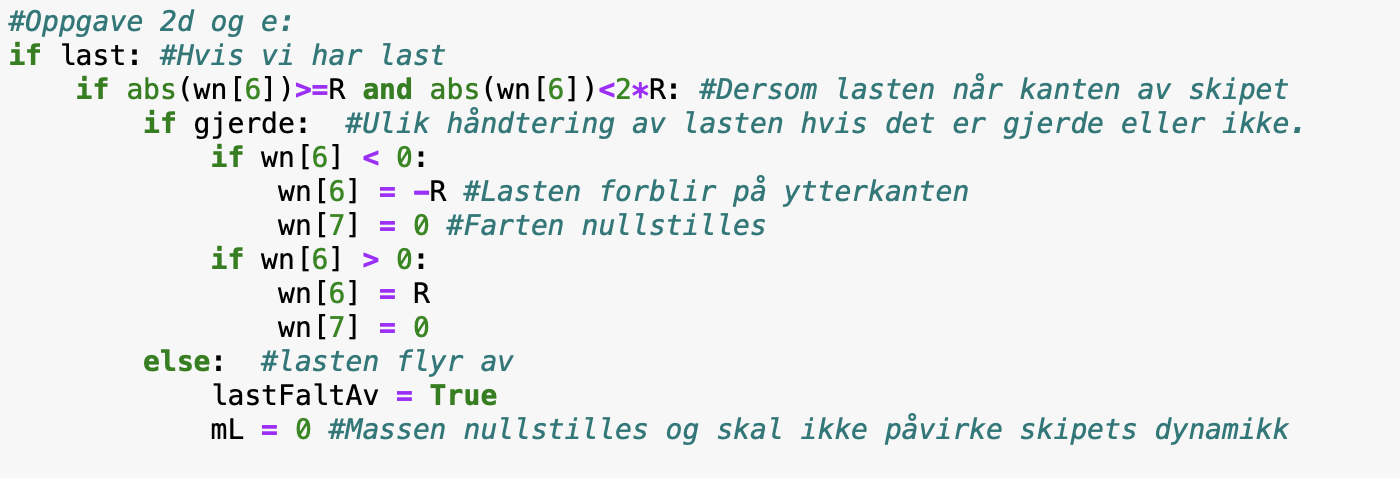

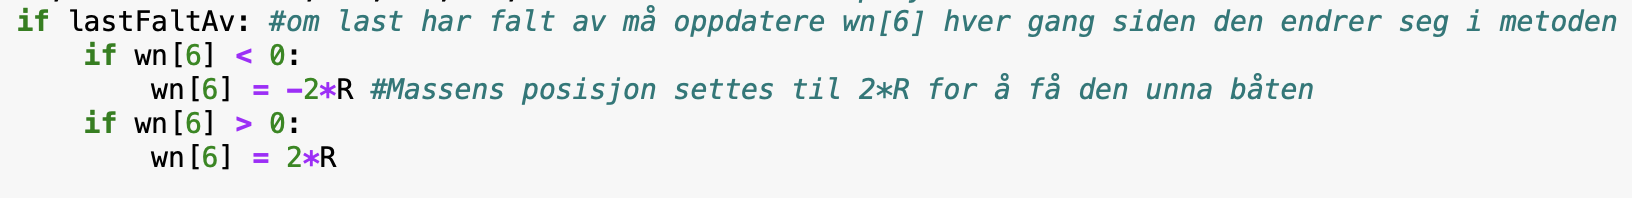

Nå skal vi se hvordan lasten påvirker skipet. Vi prøver både med en tung last (0,08 m), og en litt lettere last (0,001 m). Det plottes fra t=0 til t=40, med initialbetingelser $\theta_0= 0$ og $\omega_0 = 0.2$ rad/s og $s_L = 3$ m

In [70]:
w0Last = np.array([0, 0.2, yC0, 0, 0, 0, 3, 0])  #initialverdier

tArr0Last, wArr0Last = ode_solverGjerde(fvecLast, 0, 40, w0Last, 0.01, 0.08*m, last = True, gjerde = False) #Kjører for mL=0.08m
tArr0Last2, wArr0Last2 = ode_solverGjerde(fvecLast, 0, 40, w0Last, 0.01, 0.001*m, last = True, gjerde = False)   #Kjører for mL=0.001m

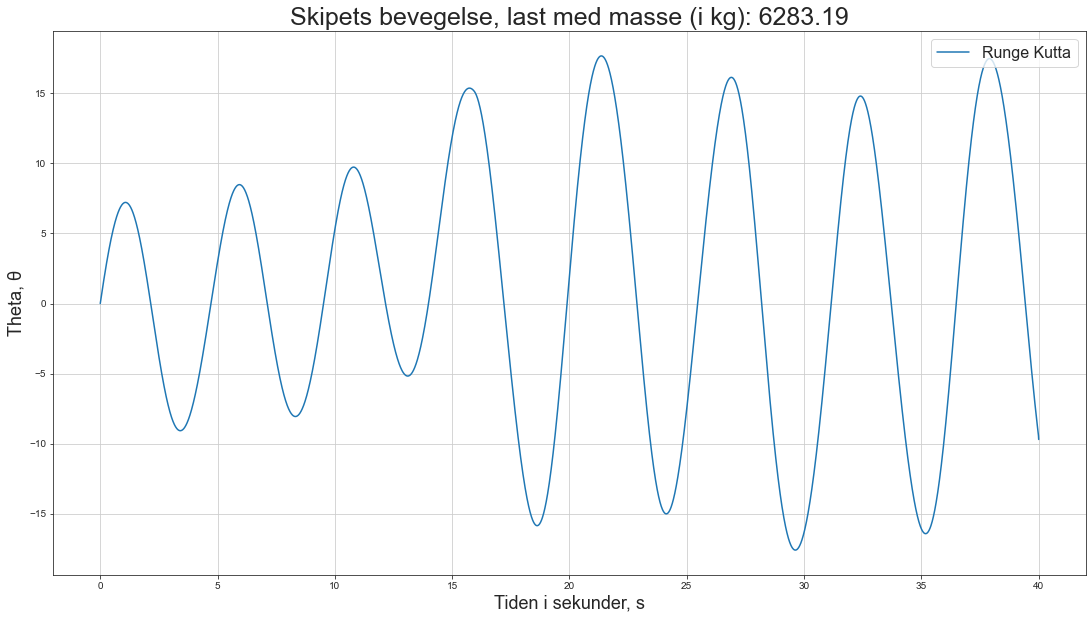

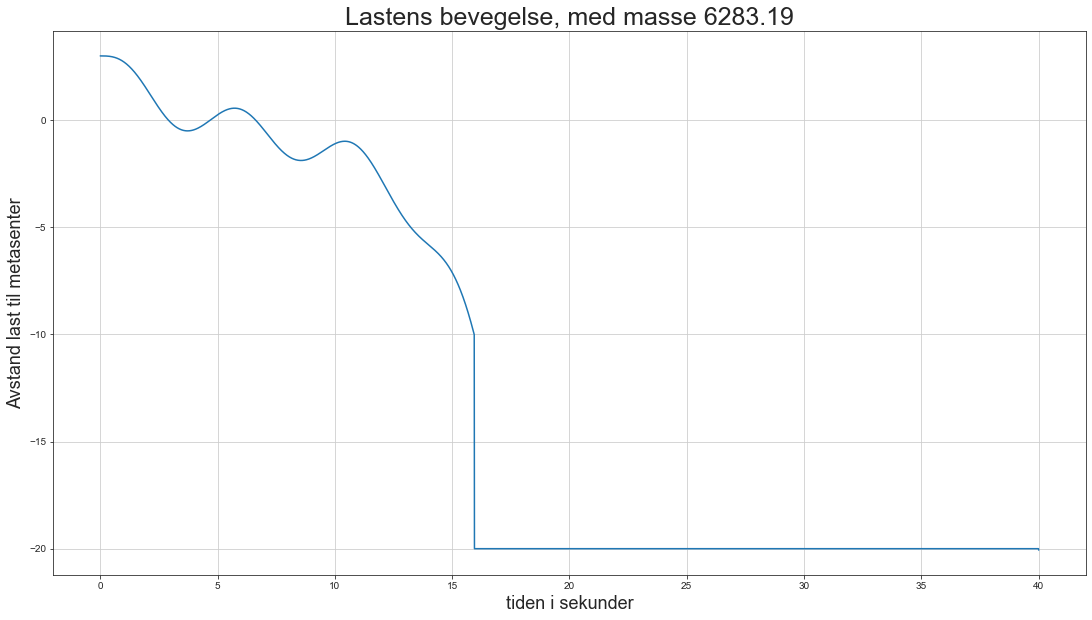

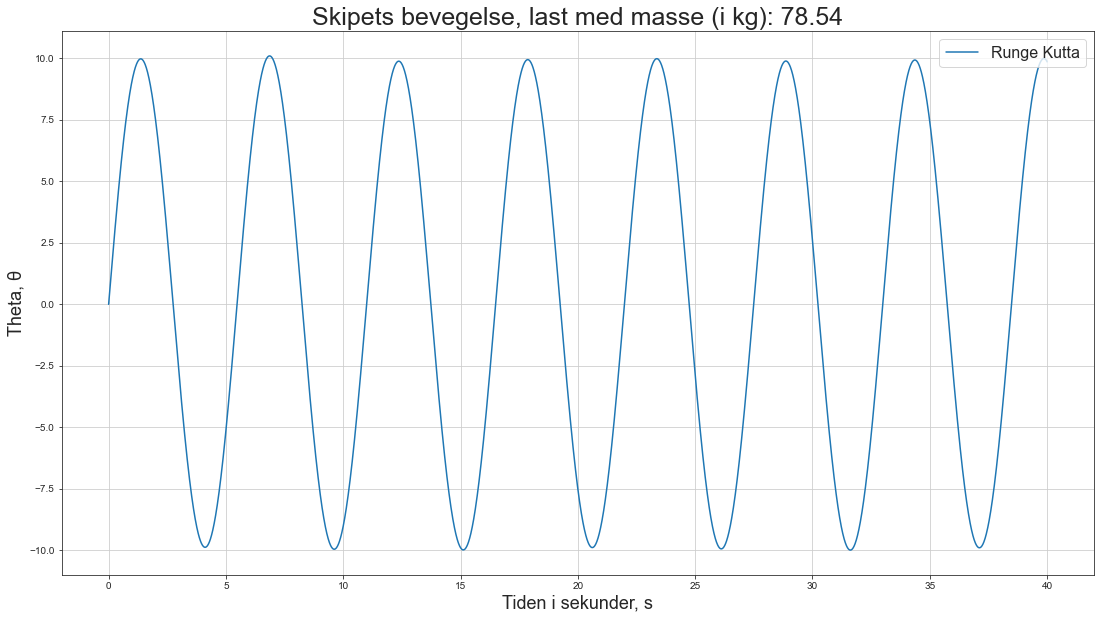

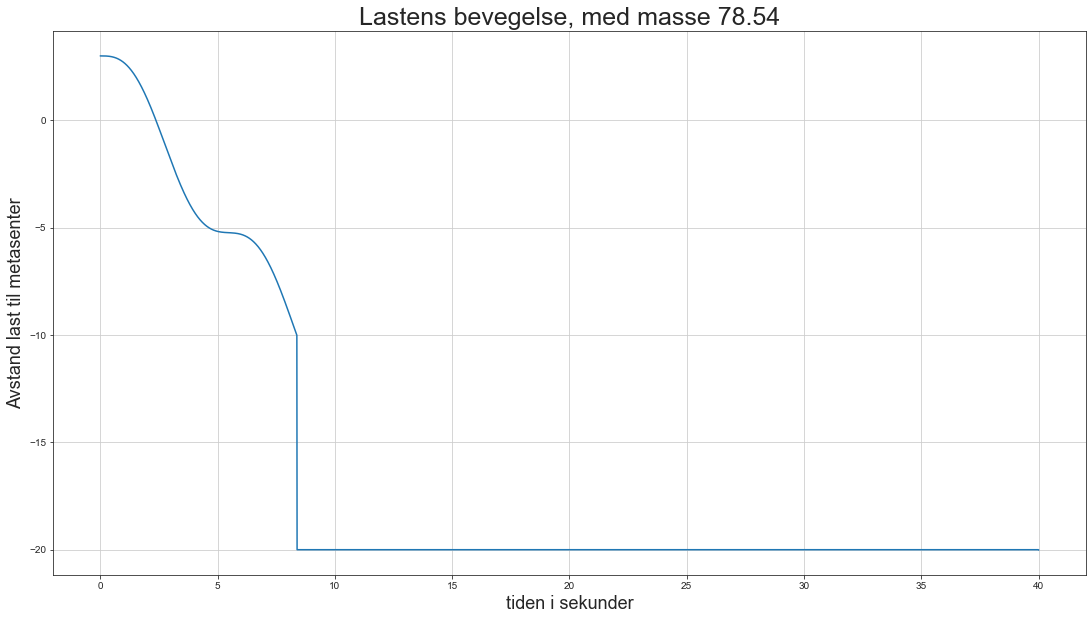

In [73]:
#plottefunksjon
def plotLast(t, w, masse):
    sl = hentUt(w, 6)
    plt.figure()
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10)
    plt.plot(t, sl)
    plt.title("Lastens bevegelse, med masse {:.2f}".format(masse), fontsize = 25)
    plt.xlabel("tiden i sekunder", fontsize = 18)
    plt.ylabel("Avstand last til metasenter", fontsize = 18)
    plt.show()

plotTheta(tArr0Last, wArr0Last, "Runge Kutta", dt, 0.08*m, last = True)
plotLast(tArr0Last, wArr0Last, 0.08*m)
plotTheta(tArr0Last2, wArr0Last2, "Runge Kutta", dt, 0.001*m, last = True)
plotLast(tArr0Last2, wArr0Last2, 0.001*m)

Det er tydelig at den tyngste lasten påvirker skipets dynamikk i mye større grad. 

Vi kan se at vinkelutslagene endres betydelig etter den tyngste lasten faller av etter ca 16 sekunder. Da får båten større vinkelutslag. Det gir mening ettersom at den tunge lasten holdt seg mest mot midten av dekket før det sklei av. Dermed var den med på å holde skipet mer stabilt, og slik redusere vinkelutslagene. 

Den letteste lasten ser ikke ut til å påvirke skipet noe særlig. Vi ser at når lasten faller av etter rundt 8 sekunder oppfører båten seg helt likt etterpå. Dette er nok fordi lasten er såpass lett at den ikke vil ha mulighet til å påvirke det tunge skipet. 

Noe annet å merke seg er at når lasten har falt av begge båtene (etter rundt 20 sekunder og utover) kunne man tenkt seg at de to grafene for $\theta$ var like. Det ser vi at de ikke er, noe som betyr at den tunge lasten påvirket skipets dynamikk såpass mye at den vil ha et endret mønster selv lenge etter den er falt av. 

### Gjerde 
#### Oppgave 1e

Vi implementerer et gjerde slik at lasten kan forbli på båten selv om den når ytterpunktet. Dette løses ved å ta inn et ekstra argument i funksjonen vår som løser likningene; ode_solver2. Vi setter gjerdet sin utgangsverdi lik “True” og må derimot skrive noe om vi ønsker å se plott uten gjerde. Dersom lasten når radiusen setter vi at den skal forbli her og at farten skal nullstilles. Kraften som overføres fra gjerdet til lasten neglisjeres. 



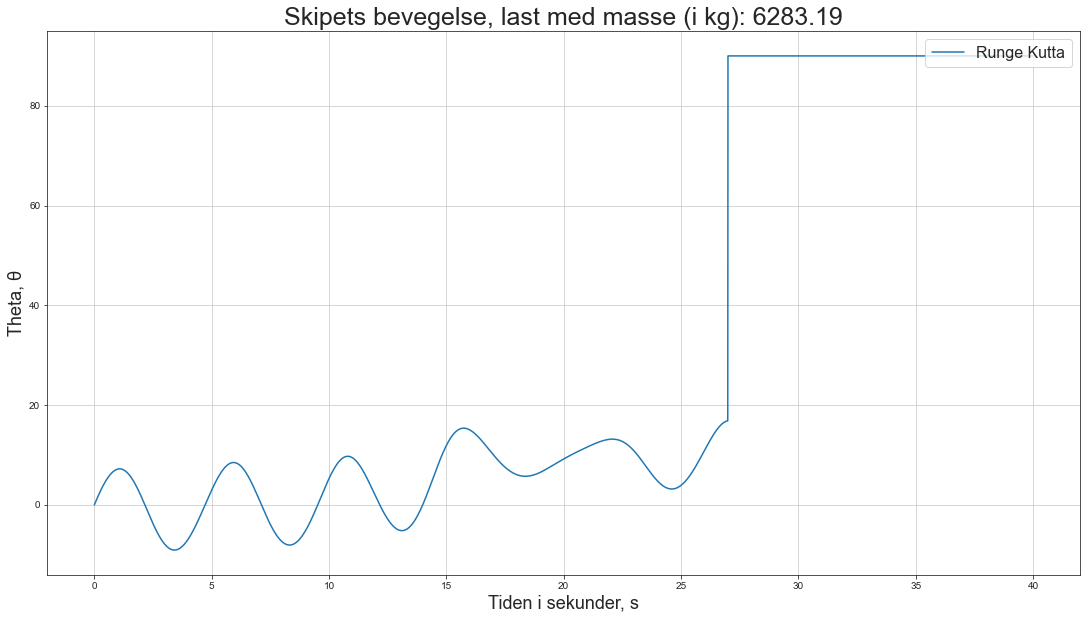

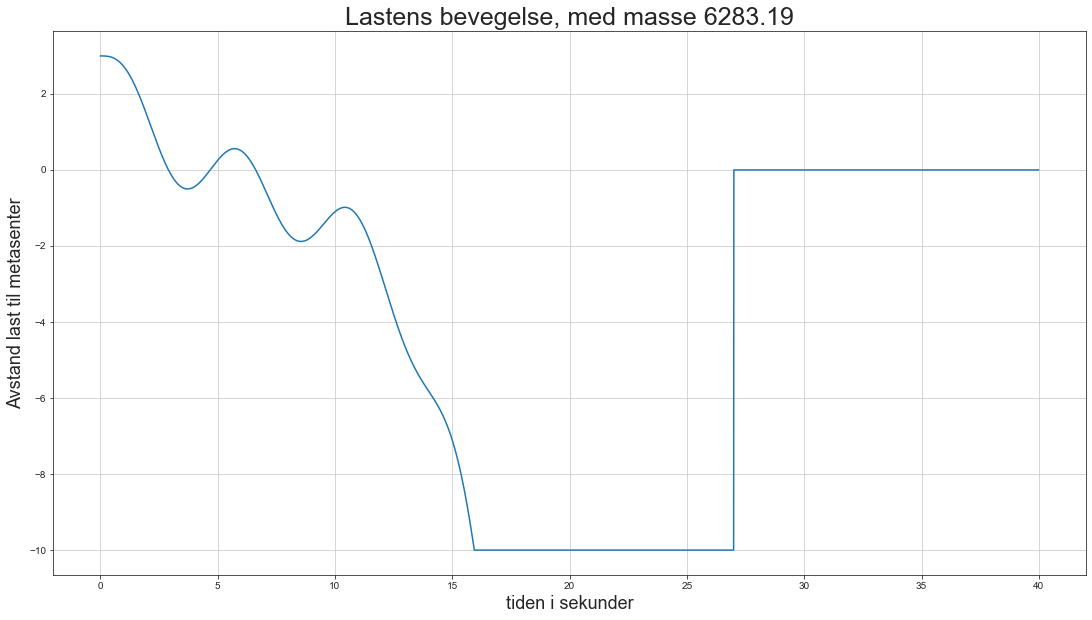

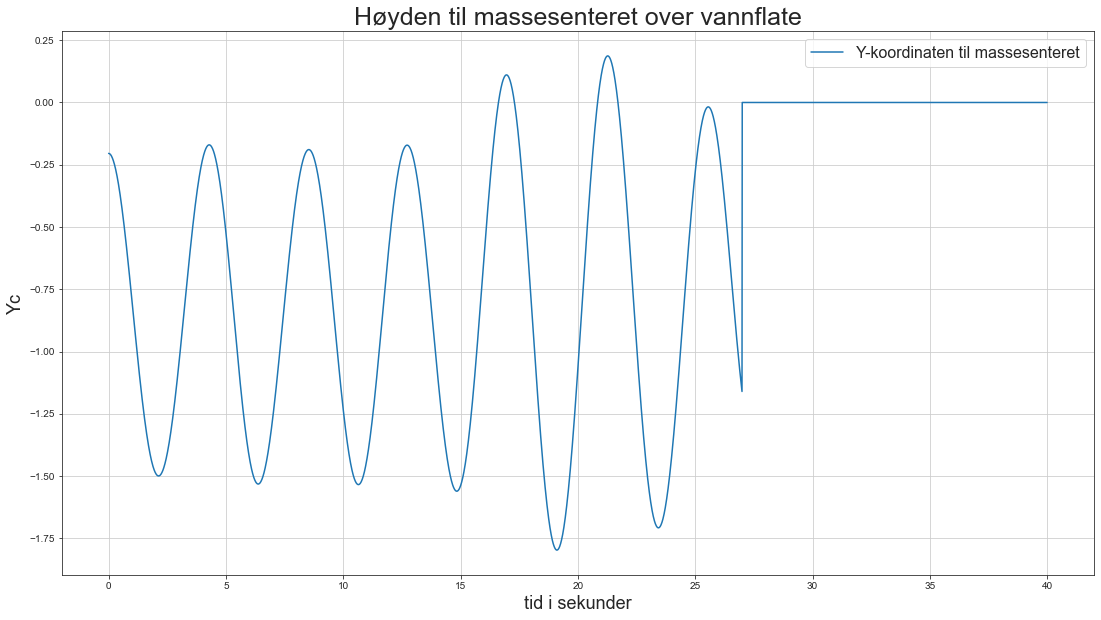

In [90]:
#Oppgave 2e

tArr0Gjerde, wArr0Gjerde = ode_solverGjerde(fvecLast, 0, 40, w0Last, 0.01, 0.08*m, last = True, gjerde = True) #Kjører for mL=0.08m
tArr0Gjerde2, wArr0Gjerde2 = ode_solverGjerde(fvecLast, 0, 40, w0Last, 0.01, 0.001*m, last = True, gjerde = True)   #Kjører for mL=0.001m
tArr0Gjerde3, wArr0Gjerde3 = ode_solverGjerde(fvecLast, 0, 40, w0Last, 0.01, 0.00, last = True, gjerde = True)   #Uten masse 

plotTheta(tArr0Gjerde, wArr0Gjerde, "Runge Kutta", dt, 0.08*m, last = True)
plotLast(tArr0Gjerde, wArr0Gjerde, 0.08*m)
plottYc(tArr0Gjerde, wArr0Gjerde)

Gjerde som ble innført gjør at dynamikken til skipet forandres mye. Her ser vi at den tyngste massen har stor påvirkning på dreiemomentet, og bidrar dermed til rotasjonen til skipet i stor grad. Vi ser at lasten blir sittende fast på den ene siden. Dette er nok fordi båten vil lene seg mot den siden med lasten på, slik at lasten aldri vil få stor nok vinkel i motsatt retning (og dermed akselerasjon) til å komme seg tilbake fra gjerdet. Etter rundt 27 sekunder kan vi se at båten kantrer, og posisjonen til lasten nullstilles. I plottet med $\theta$ legger vi merke til at $\theta$ har sin minste verdi helt i starten. Etter dette blir vinklene mer og mer positive, noe som betyr at den stadig nærmer seg kantring. 

Vi har også plottet $Y_C$. Der kan vi merke oss at amplituden øker så fort lasten setter seg fast ved gjerde. Det kan begrunnes med at lasten er med på å trekke skipet lengre ned i vannet på kanten , og dermed vil skipet fortrenge mer vann, og oppdriftkraften blir tilsvarende større. Båten får større akselerasjon oppover, og klarer derfor også å nå en høyere positiv verdi. 

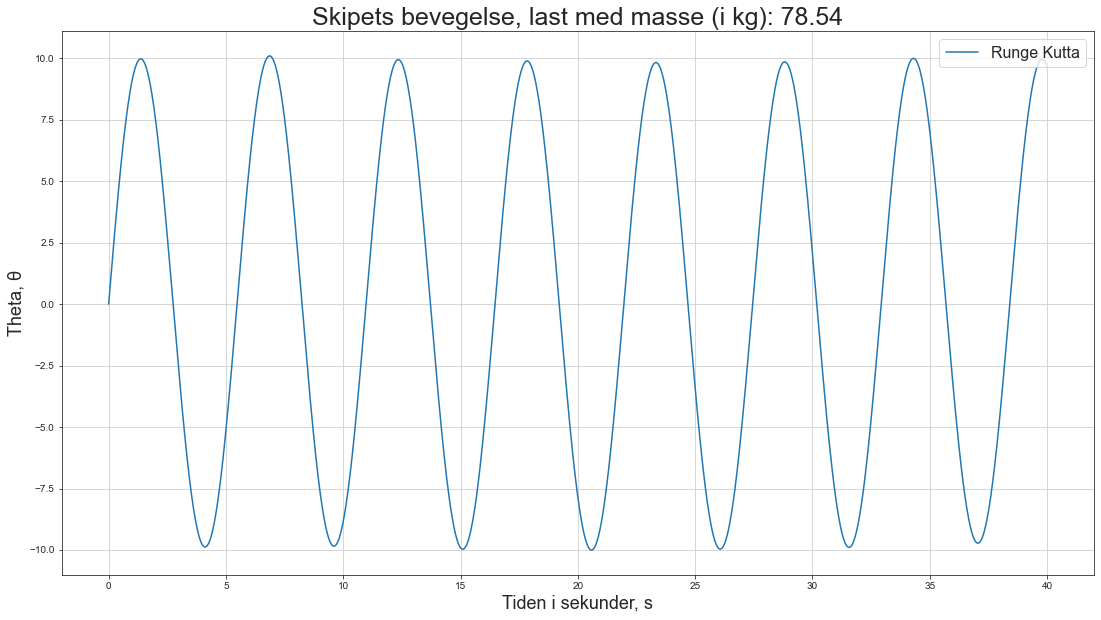

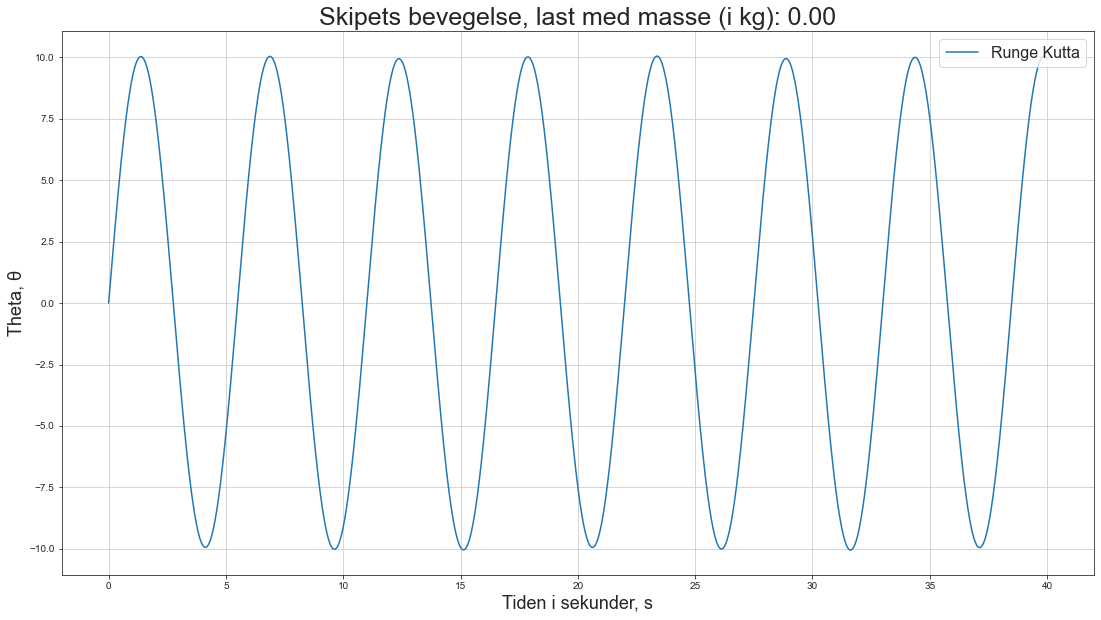

In [94]:
plotTheta(tArr0Gjerde2, wArr0Gjerde2, "Runge Kutta", dt, 0.001*m, last = True)
plotTheta(tArr0Gjerde3, wArr0Gjerde3, "Runge Kutta", dt, 0.00, last = True)

Her har vi plottet for den minste massen, og uten lasten. De to plottene ser veldig like ut på første øyekast, og det kan virke som om lasten ikke har noen særlig påvirkning på skipets dynamikk ettersom den er såpass lett. Ser man nøye kan man legge merke til at amplituden til skipet med last er noe mer varierende, og maksimalverdien til $\theta$ er ikke nøyaktig $20^\circ$ hver gang, men for noen perioder høyere og andre lavere. Dette tyder på at selv med så lett last vil skipet bli påvirket noe. 

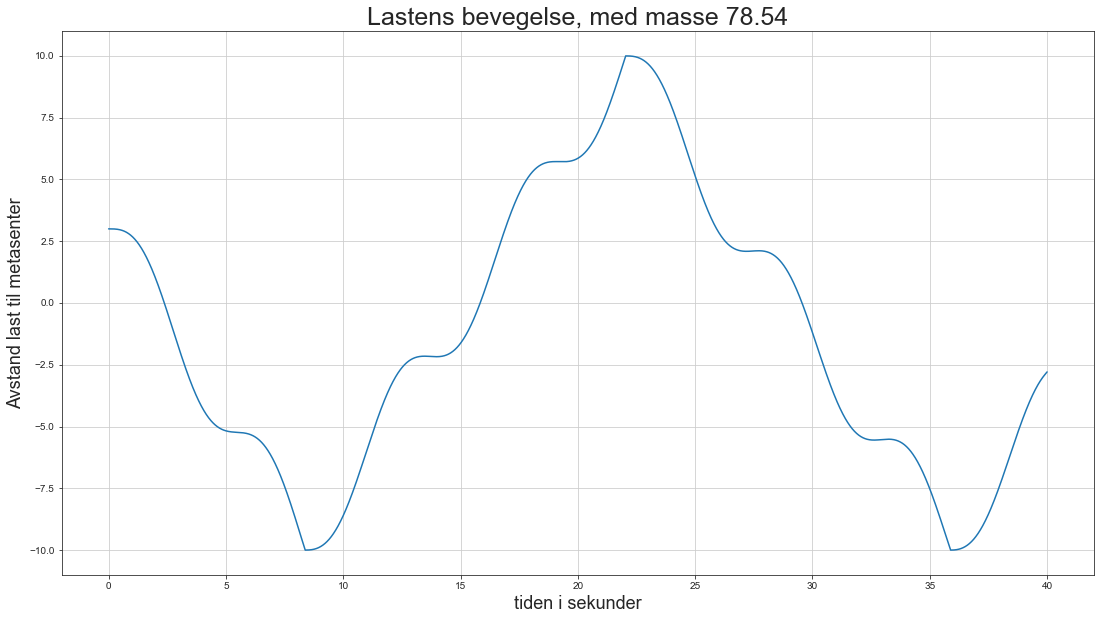

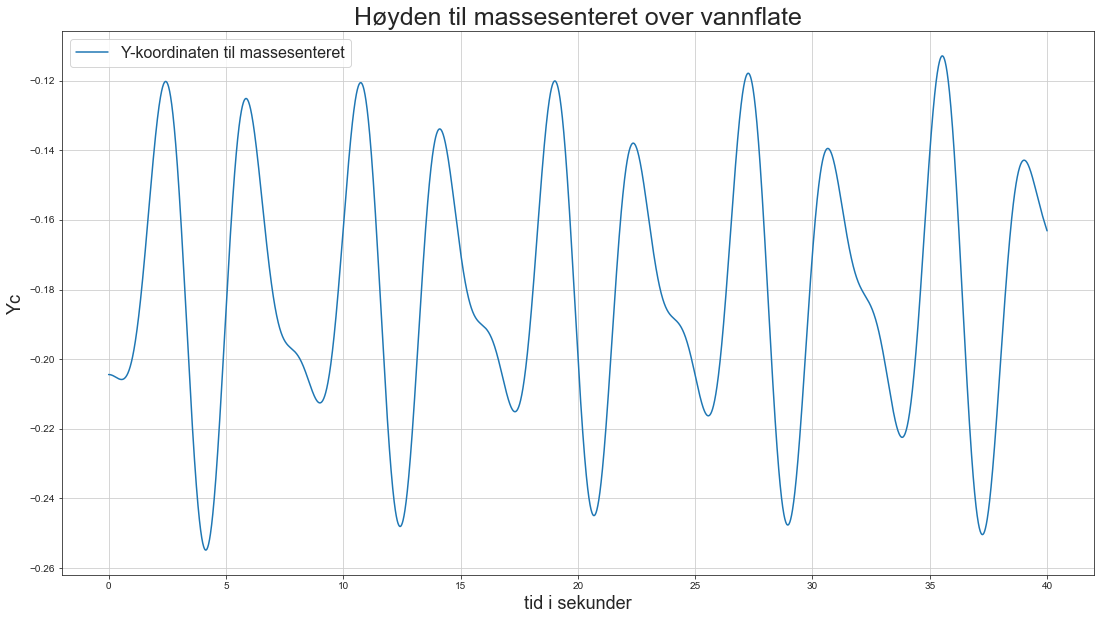

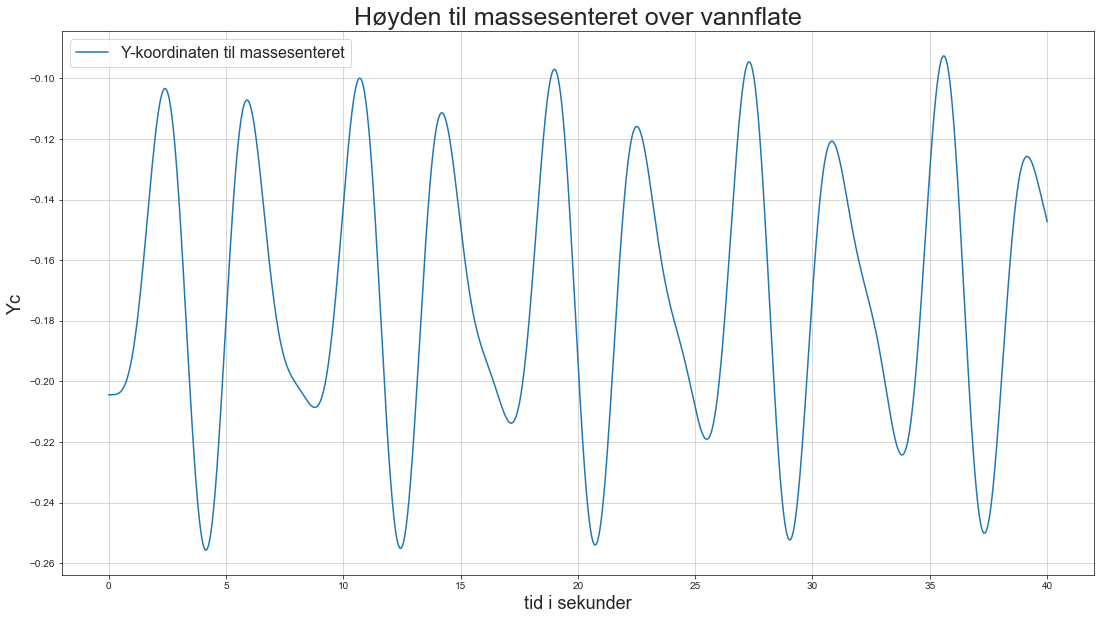

In [95]:
plotLast(tArr0Gjerde2, wArr0Gjerde2, 0.001*m)
plottYc(tArr0Gjerde2, wArr0Gjerde2)
plottYc(tArr0Gjerde3, wArr0Gjerde3)

I motsetning til den tunge lasten vil ikke den lette lasten sette seg fast ved gjerde. Dette skyldes nok at skipet ikke lener seg mot lasten sin side, slik som var tilfelle med den tunge lasten. Dermed vil skipet lene seg tilbake til motsatt side, og lasten følger tilsvarende med. 

Sammenligner vi grafene for høyden til massesenteret ser vi at mønsteret er rimelig likt. Grafen til $Y_C$ er noe mer hakkete for skipet med last, slik at lasten har en liten innvirkning her også. Vi kan likevel se at massesenteret ligger rundt 2 cm høyere for skipet uten last, noe som intuitivt også gir mening. 

Det er verdt å merke at massesenteret aldri når vannoverflaten, men alltid vil holde seg under. Dette var ikke tilfellet for den tunge lasten, hvor massesenteret var godt over vannoverflaten ved enkelte tidspunkt. 

### Friksjon og harmonisk kraft
#### Oppgave 1f

Helt til slutt ønsker vi å regne med friksjon som oppstår mellom skipets skorg og vannet, i tillegg til en harmonisk kraft som beskriver påvirkningen fra vind og bølger. 

Vi ser på en enkel modell for friksjonskreftene som virker mellom skipet og vannet. Vi kan anta at friksjonskreftene kan beskrives av følgende ligning: 

$f = -k_f R \gamma \omega \hspace{0.5cm} (x) \hspace{2cm} (14c)$

som har angrepspunkt i D. 

Vind og bølger kommer i perioder, og kan derfor tenkes at en harmonisk horisontalt rettet kraft angriper i høyde med vannlinjen: 

$F_w = F_0 cos(\omega_w\cdot t) \hspace{0.5cm} (x) \hspace{2cm} (14d)$

Summen av kreftene som nå virker på skipet vil være summen av (14a), (14b), (14c), (14d), (14e) og (14f).

De ytre kreftene vil også gi et bidrag til dreiemomentet. Friksjonen gir et dreiemoment:

$\tau_f = f(y_C-(R(cos(\gamma /2)-1)) \hspace{2cm} (15b)$

Vind og bølge kraften gir et bidrag: 

$\tau_w = F_w y_C \hspace{3cm} (15c)$

Dermed vil summen av dreiemoment være av summen av (15a), (15b), (15c) og (15d). 

Videre ønsker vi å se på hvilken påvirkning disse kreftene vil ha uten at skipet har last, så vi setter $m_L$=0 kg. 

Aller først ser vi bort i fra vind og bølger, og fokuserer bare på friksjonskraften mellom båten og vannet. Derfor setter vi $F_0 = 0$ og $\omega_w = 0$. 

Den nye $\vec{f}$ ser slik ut: 


$\vec{w}(t) = [\theta (t), \omega(t), y_C, v_{y_C}, x_C, v_{x_C}, s_L, v_L]^T$
<br>der $\omega = \frac{d\theta}{dt}, v_{y_C} = \frac{dy_C}{dt}, v_{x_C} = \frac{dx_C}{dt}, v_L = \frac{ds_L}{dt}$
<br>
Finner ny
$\vec{f} = \frac{d\vec{w}(t)}{dt}$ <br>
Vi deriverer $\vec{w}(t)$ <br>
$\frac{d\vec{w}}{dt} = [\frac{d\theta}{dt}, \frac{d\omega}{dt}, \frac{dy_C}{dt}, \frac{dv_{y_C}}{dt}, \frac{dx_C}{dt}, \frac{dv_{x_C}}{dt}, \frac{ds_L}{dt}, \frac{v_L}{dt}]^T $

Vi setter $v_L = 0$ og $s_L = 0$.
 
$\frac{d\vec{w}}{dt} = [w(t), \frac{-F_Bhsin(\theta)-f(y_C-(R(cos(\gamma/2)-1))-m_Lgcos(\theta)s_L+F_w y_C}{I_C}, v_{y_C}, \frac{-(m+mL)g+A\sigma_0g-m_Lgcos(\theta)^2}{m+m_L}, v_{x_C}, \frac{m_Lgcos(\theta)sin(\theta)-k_fR\gamma \omega +F_0cos(\omega_w t)}{m + m_L}, 0, 0]^T $
 
som gir
$\vec{f} = [\vec{w}[1], \frac{-F_Bhsin(\vec{w}[0])-f(\vec{w}[2]-R(cos(\gamma/2)-1))-m_Lgcos(\vec{w}[0])\vec{w}[6]+F_w \vec{w}[2]}{I_C}, \vec{w}[3], \frac{-(m+mL)g+A\sigma_0g-m_Lgcos(\vec{w}[0])^2}{m+m_L}, \vec{w}[5], \frac{m_Lcos(\vec{w}[0])sin(\vec{w}[0])-k_fR\gamma\vec{w}[1]+F_0(\omega_w t)}{m + m_L}, 0, 0]^T$

Vi setter $\theta_0 = 0$ og $\omega_0 = 0.4$


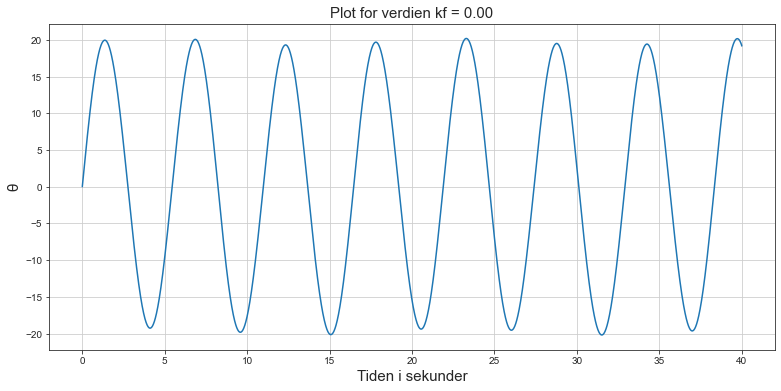

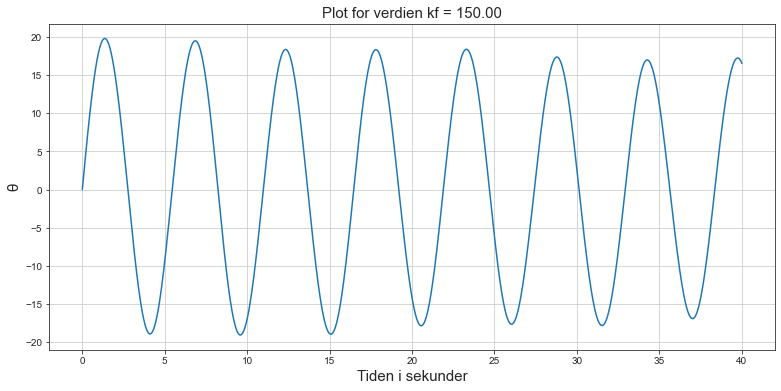

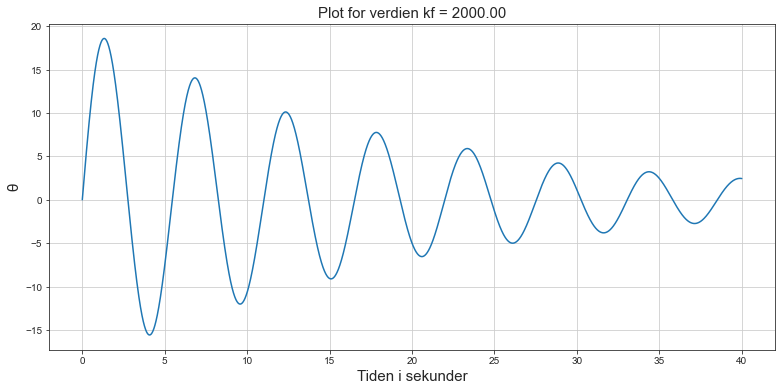

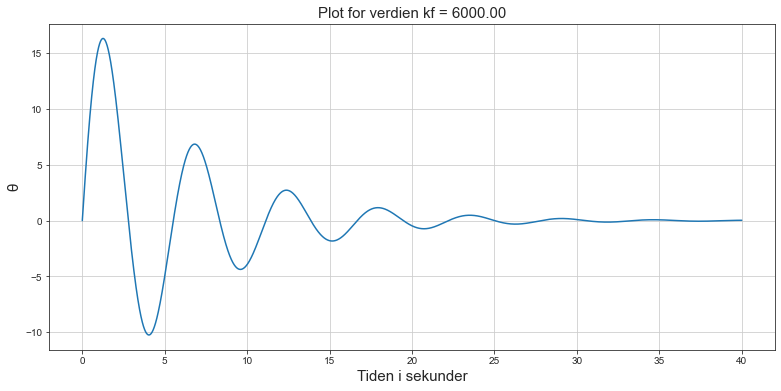

In [106]:
# Oppgave 2f
#w = np.array([theta, w, yc, vy, xc, vx, sL, vL]) 

F0 = 0 #amplituden til den harmoniske kraften
ww = 0 #grenseflatens vinkelhastighet

def fvecFriksjon(t, w, mL): #ny fvec
    '''t: tiden
    w: w-array. 8 elementer. 
    mL: massen til lasten 
    returnerer: ny w-array'''
    #Definerer nye verdier
    #Kommentar: Velger å redefinere likevektskonstantene for hver kjøring siden 
    #massen til lasten settes til 0 dersom lasten falles av, og da vil båtens likevektsegenskaper endres. 

    mNy = m + mL    #Ny masse til
    sigmaNy = mNy/A_s #massetettheten til skipet per lengdeenhet (kg/m^2)
    betaNy, nitNy = bisection(f, a, b, sigmaNy, tol=1.e-6) #Vinkelen for vannkontakten ved likevekt. Denne er konstant gjennom hele ODE_solverGjerde
    yM0, yC0, yB0, yD0 = høyder(betaNy)
    dYc = w[2]-yC0
    gamma = 2*np.arccos(np.cos(betaNy/2)-(4/(3*np.pi))*(1-np.cos(w[0]))+dYc/R)   #Vinkelen for vannkontakt
    A = 1/2*R**2*(gamma-np.sin(gamma))  #Arealet til det fortrengte vannet
    Fb = A*sigma0*g
    Ic = 1/2*m*R**2*(1-32/(9*(np.pi)**2))
    friksjon = -kf*R*gamma*w[1]
    Fw = F0*np.cos(ww*t)

    #dw/dt-vektor = f
    arr = np.array([w[1],(-Fb*h*np.sin(w[0])+friksjon*(w[2]-R*(np.cos(gamma/2)-1))-mL*g*np.cos(w[0])*w[6]+Fw*w[2])/Ic,    w[3],    (-m*g+A*sigma0*g-mL*g*(np.cos(w[0]))**2)/m,   w[5],   (-kf*R*gamma*w[1]+F0*np.cos(ww*t)+ mL*g*np.cos(w[0])*np.sin(w[0]))/m, 0, 0])   
    return arr   #np.array([w, dw/dt, vy, dvy/dt, vx, dvx/dt, vL, dvL/dt])

wf = np.array([0, 0.4, yC0, 0, 0, 0, 0, 0])
#tid0 = time.time()
#tfrik, wfrik = ode_solverGjerde(fvecFriksjon, 0, 40, wf, 0.01, 0, last = False)
#tid1 = time.time()
#print(tid1-tid0)

#plottefunksjon
def plotteK():
    tf, w = ode_solverGjerde(fvecFriksjon, 0, 40, wf, 0.01, 0, last = False)
    theta = hentTheta(w)
    plt.figure()
    plt.plot(tf, theta)
    plt.grid()
    plt.title("Plot for verdien kf = {:.2f}".format(kf), fontsize = 15)
    plt.xlabel('Tiden i sekunder', fontsize = 15)
    plt.ylabel('\u03B8', fontsize = 15)
    fig = plt.gcf()
    fig.set_size_inches(13, 6)
    plt.show()
    
# Plotter for ulike verdier av k
kf = 0
plotteK()
kf = 150
plotteK()
kf = 2000
plotteK()
kf = 6000
plotteK()

Vi studerer plottene for rolig farvann, med $k_f$-verdier: 0, 150, 2000 og 6000. Vi ser at bevegelsen blir mer dempet jo større friksjonskoeffisienten, $k_f$, er. Dette gir intuitivt mening. For $k_f$ = 0 har vi ingen demping av bevegelsen, og dette blir som å se bort i fra friksjon fullstendig. For $k_f$ = 6000 blir svingningene raskt kraftig dempet, og vi ser etterhvert at svingningene forsvinner helt. Det vil da være så mye friksjon at $\theta$ ikke vil endre seg, men forbli på $0^{\circ}$. For $k_f$ = 150 har vi en svak demping, mens $k_f$ = 2000 gir en noe kraftigere demping. Systemet mister altså energi, ettersom det virker friksjonskrefter, og amplituden vil alltid reduseres så lenge $k_f>0$.

### Vind og bølger
#### Oppgave 2g

Vi har nå studert hvilken rolle friksjonskraften spiller, og retter derfor blikket videre til den harmoniske kraften. Vi ønsker å plotte for en lengre periode fra t = 0 s til t = 240 s. For at friksjonskraften ikke skal spille en for stor rolle, setter vi $k_f$ = 100 kg/s. $F_0 = 0.625mg$ og $\omega_w = 0.93$ $\omega_0$. Initialbetingelser: $\theta_0 = 0$ og $\omega_0 = 2^\circ$/s. 

In [265]:
# Oppgave 2g
kf = 100
F0 = 0.625*m*g
w0global = np.sqrt(m*g*h/Ic)
ww = 0.93*w0global
print(0.035*w0global)
print(0.965*w0global)

w02g = np.array([0, degToRad(2), yC0, 0, 0, 0, 0, 0]) 
t2g, w2g = ode_solverGjerde(fvecFriksjon, 0, 240, w02g, 0.01, 0, last = False)

0.03993078810816341
1.1009488721250769


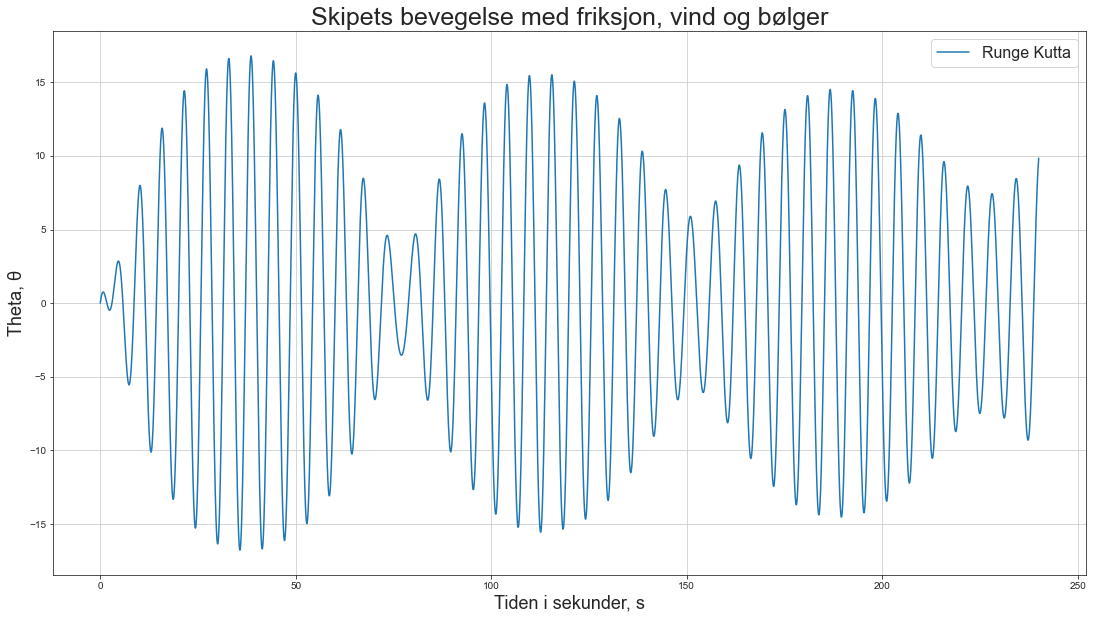

In [207]:
plotTheta(t2g, w2g, "Runge Kutta", 0.01, masse = 0, last=False, friksjon = True)

Her ser vi at vi oppnår det som kalles svevning. Dette skjer når to tidsperiodiske signaler har nesten samme frekvens. I dette tilfellet har frekvensen til vind og bølger ($\omega_w$) vinkelfrekvens som nesten er lik skipets egenfrekvens $\omega_0$. De to bølgene vil vekselvis interferere destruktivt og konstruktivt. Vi kan beskrive det totale vinkelutslaget som en superposisjon av disse. La oss se på en forenklet modell: 

$f_s(t) = sin(\omega_0 t)$<br>
$f_b(t) = sin(\omega_w t)$

hvor $f_s(t)$ og $f_b(t)$ er henholdsvis egenfrekvensen til skipet og bølger (og vind). (Vi vet at $f_b(t)$ i utgangspunktet beskrives med et cos() uttrykk, men dette kan gjøres om til et sinusuttryk ved et enkelt faseskift. For enkelhetsskyld ser vi bort i fra dette nå, da det er uviktig for å få frem poenget.)

$f_s(t) + f_b(t) = sin(\omega_0 t) + sin(\omega_w t) = 2sin((\omega_0 + \omega_w)t/2)cos((\omega_0 - \omega_w)t/2)$

Sinusfaktoren i uttrykket vil gi bidrag til en høyfrekvent svingning, mens cosinusfaktoren bidrar til lavfrekvens svingning. 

De lavfrekvente bølgene (de store bølgene) varierer med en frekvens lik : 

$\frac{\omega_0 - \omega_w}{2}$ = $0.035 \omega_0$ = 0.04 rad/s. 

Mens frekvensen til resultantbølgen blir: 

$\frac{\omega_0 + \omega_w}{2}$ = $0.965 \omega_0$ = 1.10 rad/s. 

(kilde: Svevning, Støvning)

Dette ser ut til å stemme godt med plottet vårt. Dessuten ser vi at bølgene også dempes litt, noe som skyldes friksjonskraften. 

## Kreativ del
### Ny ode-løser
#### Oppgave 2h


Innledningsvis ønsker vi å implementere bogacki shampine metoden, som er en Runge Kutta metode av orden tre. Den ligner veldig på RK4, men baserer seg på et prinsipp vi kaller FSAL (first same as last). Som går ut på at vi kan gjøre ferre funksjonsevalueringer, fordi den første verdien vi bruker vil være den siste fra forrige iterasjon. k4 i et steg er altså det samme som k1 i forrige steg. Dermed kan det tenkes at denne er noe raskere enn RK4. 

Vi implementerer en tilpasningsdyktig ode solver (adaptive, som vi kopierte fra dokumentet). Fordelen med en tilpasningsdyktig løser er at den vil prøve med ulike steglengder i hver iterasjon. Dersom den ser at den lokale feilen er mye mindre enn toleransen kan steglengden økes. Og omvendt, om den lokale feilen er mye større enn toleransen vil steglengden måtte senkes. Ulempen er at noen iterasjoner må gjøres om igjen med nye steglengder, men likevel vil en slik løser totalt sett kunne virke mye bedre enn en som ikke er tilpasningsdyktig. 



In [266]:
def bogshamp(k1, f, x, y, h):
    '''
    One step with the pair Bogacki Shampine
    Input: the function f, the present state xn and yn  and the stepsize h
    Output: the solution x and y in the next step, error estimate, and the
            order p of the Runge Kutta method (the lowest order)
    '''
    #k1 = f(x, y)
    mL = 0
    k2 = f(x + 1/2*h, y + 1/2*h*k1, mL)
    k3 = f(x + 3/4*h, y + 3/4*h*k2, mL)
    y_next = y + 2/9*h*k1 + 1/3*h*k2 + 4/9*h*k3     # Heuns metode (lokal ekstrapolasjon)

    x_next = x + h
    
    k4 = f(x + h, y_next, mL)
    z_next = y + 7/24*h*k1 + 1/4*h*k2 + 1/3*h*k3 + 1/8*h*k4
    
    error_estimate = h*norm(((7/24-2/9)*k1 + (1/4-1/3)*k2 + (1/3-4/9)*k3 + (1/8-0)*k4))  # The 2-norm or the error estimate
    p = 2
    return k4, x_next, y_next, error_estimate, p
    

def ode_adaptive(P, f, x0, xend, y0, h0, mL, tol = 1.e-6, last = False, gjerde = True,method=bogshamp):
    '''
    Adaptive solver for ODEs
        y' = f(x,y), y(x0)=y0
     
    Input: the function f, x0, xend, and the initial value y0
            intial stepsize h, the tolerance tol, 
             and a function (method) implementing one step of a pair.
    Ut: Array med x- og y- verdier. 
    '''

    y_num = np.array([y0])    # Array for the solutions y
    x_num = np.array([x0])    # Array for the x-values

    xn = x0                # Running values for  x, y and the stepsize h
    yn = y0 
    h = h0
    Maxcall = 100000        # Maximum allowed calls of method
    ncall = 0
    k1 = f(x0, y0, mL)
    fevals = 0
    Kantre = False
    # Main loop
    while xend- xn>0:               # Buffer for truncation error
        # Adjust the stepsize for the last step
        if xn + h > xend:                   
            h = xend - xn 
        
        # Do one step with your chosen method
        k1, x_try, y_try, error_estimate, p = method(k1, f, xn, yn, h)
        ncall = ncall + 1
        fevals += 3
        #print(error_estimate)
        if error_estimate <= tol:
            
            # Solution accepted, update x and y
            xn = x_try    
            yn = y_try
            # Store the solutions 
            y_num = np.concatenate((y_num, np.array([yn])))
            x_num = np.append(x_num, xn)
        
        # else: The step rejectes and nothing is updated. 
        
        # Adjust the stepsize
        h = P*(tol/error_estimate)**(1/(p+1))*h
        
        #relevant for kreativ oppgave lengre nede: 
        dYc = yn[2]-yC0   #Finner dYc 
        gamma = 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(yn[0]))+dYc/R) #Finner gamma
        kanteKrav = (np.pi- gamma)/2 #Ved denne verien kantrer skipet
        if yn[0] > kanteKrav:
            Kantre = True
            return x_num, y_num, Kantre
        
        # Stop with a warning in the case of max calls to method
        if ncall > Maxcall:
            print('Maximum number of method calls')
            return x_num, y_num

    # Some diagnostic output
   # print(f'Number of accepted steps = {len(x_num)-1:4d}')
   # print(f'Number of rejected steps = {ncall-len(x_num)+1:4d}')
   # print(f'Number of function1.694 evaluations = {fevals}')
    return x_num, y_num, Kantre



#w02h = np.array([0, 0, 0, 0, 0, 0, 0, 0])
w02h = np.array([0, degToRad(2), yC0, 0, 0, 0, 0, 0]) 
t0Bog = time.time()
t_numBog, w_numBog, kantre = ode_adaptive(0.9, fvecFriksjon, 0, 240, w02h, 0.01, 0, tol = 1.9*10**-4, method=bogshamp)
t1Bog = time.time()

t0RK = time.time()
t, w = ode_solverGjerde(fvecFriksjon, 0, 240, w02h, 0.1, 0, last=False)
t1RK = time.time()

thetabog = hentTheta(w_numBog)
theta = hentTheta(w)

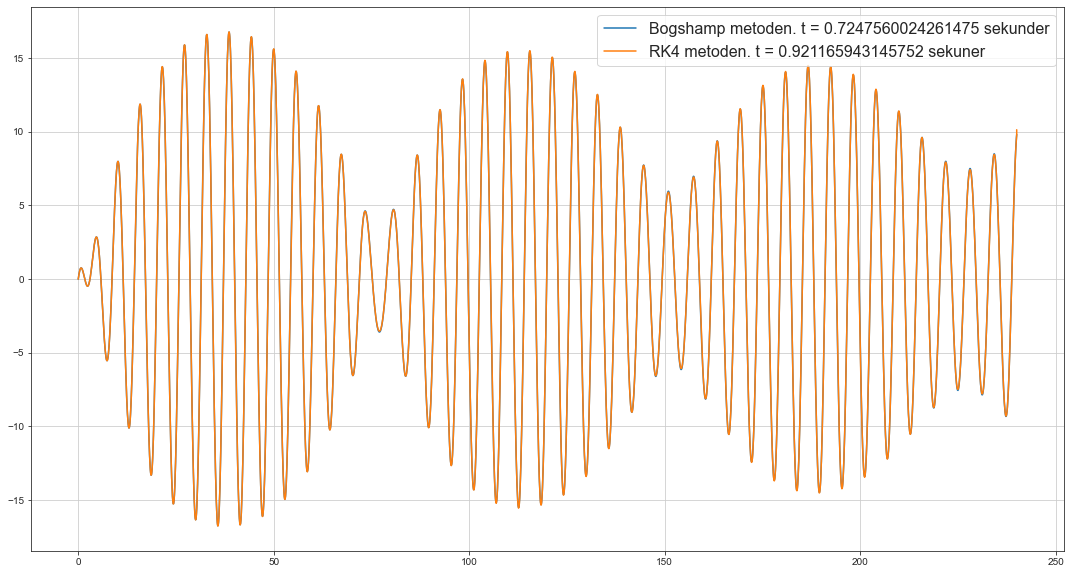

Bogshamp brukte  0.7247560024261475 sekunder
RK4 brukte  0.921165943145752 sekunder
Bogshamp har gjort  2416 iterasjoner
RK4 har gjort  2402 iterasjoner


In [268]:
plt.figure()
plt.plot(t_numBog, thetabog, label = f'Bogshamp metoden. t = {t1Bog-t0Bog} sekunder')
plt.plot(t, theta, label = f'RK4 metoden. t = {t1RK - t0RK} sekuner')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10)
plt.legend()
plt.show()

print('Bogshamp brukte ',  t1Bog-t0Bog,'sekunder')
print('RK4 brukte ', t1RK-t0RK, 'sekunder')
print('Bogshamp har gjort ', len(t_numBog), 'iterasjoner')
print('RK4 har gjort ', len(t), 'iterasjoner')


Nå kan vi sammenligne de to metodene. Vi justerte toleransen til bogshamp slik at antall iterasjoner skulle være omtrent det samme for de to metodene. Da ser vi at Bogshamp metoden er bittelitt raskere enn RK4 metoden, som forventet. Likevel blir det vanskelig å sammenligne de to metodene uten å vite hvor nøyaktig RK4 metoden vår er, ettersom denne ikke blir kalkulert ut i fra noen bestemt toleranse, men bruker en bestemt steglengde. Basert på plottet vårt virker det som de to løsningene er nærmest identiske, og vi konkluderer derfor med at feilestimatet er omtrent likt for de to metodene. De er altså så og si like gode, selv om RK4 er en en fjerdeordens metode mot bogshamp som er en tredjeordens. Videre vil det være mer interessant å samenligne metoder av flere ulike ordener, og måle de opp mot hverandre med samme toleranse for feilen. 

### Sammenligne metoder av ulik orden

Videre ønsker vi å sammenlikne ulike metoder for løsning av differensiallikningene vår. Vi bruker den innebygde løseren til scipy, integrate.solve_ivp, og løser med fire ulike metoder; RK45, RK23, DOP853 og LSODA. Dette gjør vi for å finne metoden som er mest effektiv. 

Ettersom vi i tidligere oppgaver brukte RK4 som løser, og vi vet at denne er en eksplistitt løser, vil vi tro at vi har et problem med en ikke-stiv ode som skal løses. Derfor valgte vi følgende metoder. 

Vet fra før at RK45 gjør funksjonsevalueringer av 5. orden, der feilen er av 4. orden. Det er en eksplisitt løser. 

RK23 gjør funksjonsevalueringer av 3. orden, der feilen er av 2. orden. Dette er også en eksplisitt løser. 

LSODA er mulig å bruke til både stive og ikke-stive ODE, denne metoden vil tilpasse seg diffligningen. 

DOP 853 8. ordens metode, som også er en eksplisitt løser. 

Eksplisitte Runge Kutta metoder er spesielt godt egnet for å løse ikke-stive problemer i motsetning til implisitte metoder som ‘Radau’ og ‘BDF’ som er godt egnet til å løse stive problemer. Løser også med LSODA, som er en god universell som detekterer om problemet er “stiff” eller “non stiff”, som er grunnen til at vi også bruker denne i sammenligningen. DOP 853 er spesielt egnet for å løse med høy presisjon da dette er en 8. ordens løser. 


scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options) henter en funksjon fun, en tuple med start- og slutt-tid, y0 som her er w0-vektor, samt metoden vi ønsker å bruke. De neste funksjonsparametrene er valgfrie. 

Løseren returnerer en “bunch” med verdier, som blant annet inneholder en array med t-verdiene og en array med w-vektor-verdiene for hver t-verdi. W-vektoren er ordnet som den transponerte av løsningen vår fra de forrige oppgavene, altså er theta-verdiene plass nummer 0, w-verdiene er plass nummer 1 osv. (tidligere har theta-verdiene vært på den 0-te plassen i hvert array-element)

Steglengden vil variere ettersom denne løseren er tilpasningsdyktig, og bruker det tidssteget som vil være optimalt for hver iterasjon. 

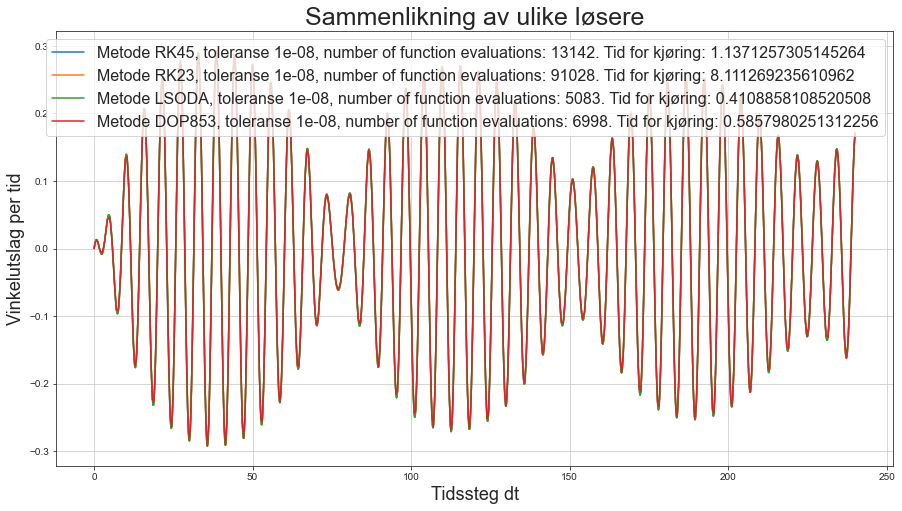

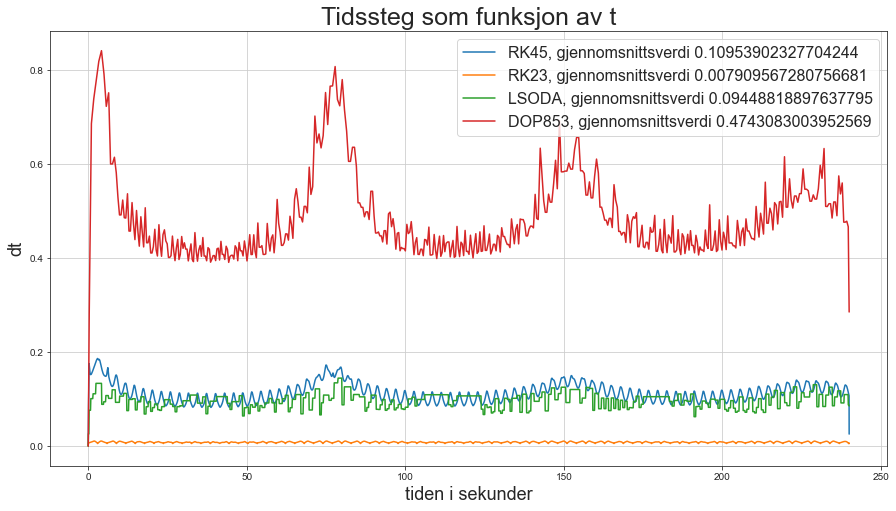

Lengre tidssteg vil gi en mer effektiv løser, men ikke nødvendigvis et mer nøyaktig resultat


In [125]:
#Prøver med innebygd scipysolverer for ulike metoder. 
kf = 100
F0 = 0.625*m*g
w0global = np.sqrt(m*g*h/Ic)
ww = 0.93*w0global

wtry = np.array([0, degToRad(2), yC0, 0, 0, 0, 0, 0]) 

def fvecscipy(t, w):
    '''t: tiden
    w: w-array. 8 elementer. 
    mL: massen til lasten 
    returnerer: ny w-array'''
    #Definerer nye verdier
    mL=0
    mNy = m + mL    #Ny masse til
    sigmaNy = mNy/A_s #massetettheten til skipet per lengdeenhet (kg/m^2)
    betaNy, nitNy = bisection(f, a, b, sigmaNy, tol=1.e-6) #Vinkelen for vannkontakten ved likevekt. Denne er konstant gjennom hele ODE_solverGjerde
    dYc = w[2]-yC0
    gamma = 2*np.arccos(np.cos(betaNy/2)-(4/(3*np.pi))*(1-np.cos(w[0]))+dYc/R)   #Vinkelen for vannkontakt
    A = 1/2*R**2*(gamma-np.sin(gamma))  #Arealet til det fortrengte vannet
    Fb = A*sigma0*g
    Ic = 1/2*m*R**2*(1-32/(9*(np.pi)**2))
    friksjon = -kf*R*gamma*w[1]
    Fw = F0*np.cos(ww*t)
    arr = np.array([w[1],(-Fb*h*np.sin(w[0])+friksjon*(w[2]-R*(np.cos(gamma/2)-1))-mL*g*np.cos(w[0])*w[6]+Fw*w[2])/Ic,    w[3],    (-m*g+A*sigma0*g-mL*g*(np.cos(w[0]))**2)/m,   w[5],   (-kf*R*gamma*w[1]+F0*np.cos(ww*t)+ mL*g*np.cos(w[0])*np.sin(w[0]))/m, 0, 0])   
    return arr   #np.array([w, dw/dt, vy, dvy/dt, vx, dvx/dt, vL, dvL/dt])



def hentDt(t):     
    dtArr = np.zeros(len(t))
    for i in range(1,len(t)):
        dtArr[i] = t[i]-t[i-1]
    return dtArr


def sammenliknerMetoder(metode1, metode2, metode3, metode4, f, t0, tend, w0, rtol, atol):
    tid0 = time.time()
    
    resultat1 = scipy.integrate.solve_ivp(f, (t0, tend), w0, method=metode1, rtol = rtol, atol = atol)
    tid1 = time.time()
    resultat2 = scipy.integrate.solve_ivp(f, (t0, tend), w0, method=metode2, rtol=rtol, atol = atol)
    tid2 = time.time()
    resultat3 = scipy.integrate.solve_ivp(f, (t0, tend), w0, method=metode3, rtol=rtol, atol = atol)
    tid3 = time.time()
    resultat4 = scipy.integrate.solve_ivp(f, (t0, tend), w0, method=metode4, rtol=rtol, atol = atol)
    tid4 = time.time()
    #Figur1: sammenlikner løsningene
    plt.plot(resultat1.t, resultat1.y[0], label = f'Metode {metode1}, toleranse {rtol}, number of function evaluations: {resultat1.nfev}. Tid for kjøring: {tid1-tid0}')
    plt.plot(resultat2.t, resultat2.y[0], label = f'Metode {metode2}, toleranse {rtol}, number of function evaluations: {resultat2.nfev}. Tid for kjøring: {tid2-tid1}')
    plt.plot(resultat3.t, resultat3.y[0], label = f'Metode {metode3}, toleranse {rtol}, number of function evaluations: {resultat3.nfev}. Tid for kjøring: {tid3-tid2}')
    plt.plot(resultat4.t, resultat4.y[0], label = f'Metode {metode4}, toleranse {rtol}, number of function evaluations: {resultat4.nfev}. Tid for kjøring: {tid4-tid3}')
    plt.grid()
    plt.title('Sammenlikning av ulike løsere', fontsize = 25)
    plt.xlabel('Tidssteg dt', fontsize = 18)
    plt.ylabel('Vinkelutslag per tid', fontsize = 18)
    fig = plt.gcf()
    fig.set_size_inches(15, 8)
    plt.legend()
    plt.show()

    #Figur2: Sammenlikner tidsstegene for hver løsning
    dt1, dt2, dt3, dt4 = hentDt(resultat1.t), hentDt(resultat2.t), hentDt(resultat3.t), hentDt(resultat4.t)
    plt.plot(resultat1.t, dt1, label = f'{metode1}, gjennomsnittsverdi {np.mean(dt1)}')
    plt.plot(resultat2.t, dt2, label = f'{metode2}, gjennomsnittsverdi {np.mean(dt2)}')
    plt.plot(resultat3.t, dt3, label = f'{metode3}, gjennomsnittsverdi {np.mean(dt3)}')
    plt.plot(resultat4.t, dt4, label = f'{metode4}, gjennomsnittsverdi {np.mean(dt4)}')
    plt.grid()
    plt.title('Tidssteg som funksjon av t', fontsize = 25)
    plt.xlabel( "tiden i sekunder", fontsize = 18)
    plt.ylabel("dt", fontsize = 18)
    fig = plt.gcf()
    fig.set_size_inches(15, 8)
    plt.legend()
    plt.show()

    print('Lengre tidssteg vil gi en mer effektiv løser, men ikke nødvendigvis et mer nøyaktig resultat')
    #return resultat1.nfev, resultat2.nfev, resultat3.nfev, resultat4.nfev, tid1-tid0, tid2-tid1, tid3-tid2, tid4-tid3

sammenliknerMetoder('RK45', 'RK23', 'LSODA', 'DOP853', fvecscipy, 0, 240, wtry, 1e-8, 1e-8)


Tester løseren for ulike toleranser. Vi vet fra dokumentet *Numerical solutions of ordinary differential equations* at <br>
$\frac {Tol_1}{Tol_2}^\frac{1}{p+1} $ $\approx \frac{N_2}{N_2}$

for ikke-stive ODE. 

Ser derfor at hvis vi for eksempel ser på RK23 som er av orden p=3, vil en reduksjon på en faktor 10 i toleranse (f.eks fra $10^{-3}$ til $10^{-4}$) gi en økning i antall steg på ca. 1.8. Dette kan vi verifisere ved å kjøre funksjonen over for tol = $10^{-4}$ og tol = $10^{-5}$

Videre fortsetter vi slik for ulike toleranser og metoder, og verifiserer på denne måten at vi har med et ikke-stivt problem å gjøre ettersom antall steg er avhengig av toleransen. Dette gir også intuitivt mening ettersom vi ikke har noen veldig ekstreme faktorer som raskt vil endre løsningen vår til differensialligningen. Finner at tol = $10^{-8}$ er en god toleranse å bruke for sammenligning.

Med tol = $10^{-8}$ vil alle løsningene ha en svært liten feil, og det vil bli mest relevant å sammenligne kjøretid, funksjonsevalueringer og steglengde. 

Vi sammenligner de eksplisitte løserne først: 

Vi kan se at den raskeste metoden er DOP853. Dette er metoden av høyest orden. Det er også den metoden som gjør ferrest funksjonsevalueringer, og dette resulterer i at den har størst steglengde dt. Den har også mest varierende steglengde, noe som er positivt at løseren bare bruker små steglengder der det vil være nødvendig. 

Den treigeste løseren er RK23, som også har den laveste ordenen. Den bruker nesten 14 ganger så lang tid som DOP853. Denne gjør også flest funksjonsevalueringer, og har den minste steglengden. Lavere ordens metoder trenger mindre steglengde for å få en liten nok feil. Dermed vil den bruke lengre tid for å oppnå samme nøyaktighet som en høyere ordens metode. 

RK45 ligger mellom de to andre i både orden, kjøretid, funksjonsevalueringer og steglengde, som forventet. Vi ser likvel at tiden er ganske mye mindre enn for RK23, så det hjelper veldig å gå opp to ordener. 

Sammenligner vi med LSODA ser vi at dette er den raskeste av de alle, og den med ferrest funksjonsevalueringer. Likevel har den mye mindre steglengde enn DOP853. Steglengden er omtrent lik steglengden for RK45. Det kan diskuteres om det er relevant å sammenligne med denne metoden, ettersom vi vet lite om den, og at det er den eneste metoden som ikke er ren eksplisitt. Den er tilpasningsdyktig til alle mulige situasjoner, noe som for oss til å tro at den vil være veldig vanskelig å implementere. 

Det at DOP853 kom best ut av sammenligningen av de eksplisitte betyr ikke at dette nødvendigvis er den beste metoden. Ettersom det er en metode av grad 8 vil det tenkes at den er mye vanskeligere å implementere enn en tredjeordens metode. Nå slapp vi heldigvis å implementere alle disse metodene ettersom scipy gjorde det for oss. Men om man skal implementere metodene selv bør man veie kjøretid/presisjon mot vanskelighetsgraden av implementasjonen. 

### Resonans

Resonans er et fenomen som forekommer når en harmonisk kraft påvirker et systemet med en frekvens som er lik egenfrekvensen til systemet. Egenfrekvensen til systemet er frekvensen systemet får når den blir overlatt til seg selv. Vi har tidligere sett at denne er lik 

$\omega = \sqrt(\frac{m\cdot h\cdot g}{I_C})$

Det forventes derfor at skipet vårt vil kunne kantre om vi gir den en slik verdi, selv for lave verdier av $\omega_0$ og $\theta_0$. 

Vi ønsker å se nærmere på dette. Og vil nå bruke bogshamp metoden som vi implementerte tidligere i den kreative delen. Der la vi inn en setning som sjekket hver $\theta$ verdi om den oppfylte kantrekravene, og dermed returnerer True eller False for kantring. 

In [275]:
#Finne om båten kantrer eller ikke for ulike verdier av w
w02g = np.array([0, degToRad(2), yC0, 0, 0, 0, 0, 0]) 
kf = 50
F0 = 0.625*m*g*1.8
omega = np.sqrt(m*h*g/Ic)

wOmega = np.linspace(0.9, 1.25, 100)
trueOrFalse = np.zeros(len(wOmega))

for i in range(len(wOmega)): 
    ww = wOmega[i]
    tider, omegaVerdier, Kantre = ode_adaptive(0.9, fvecFriksjon, 0, 50, w02g, 0.01, 0, tol = 1.e-4)
    if Kantre: #Dersom skipet vårt har kantret
        trueOrFalse[i] = 1 #Dersom kantret, legger til "1"
    else:
        trueOrFalse[i] = 0 #Dersom den ikke kantret, legger til "0"

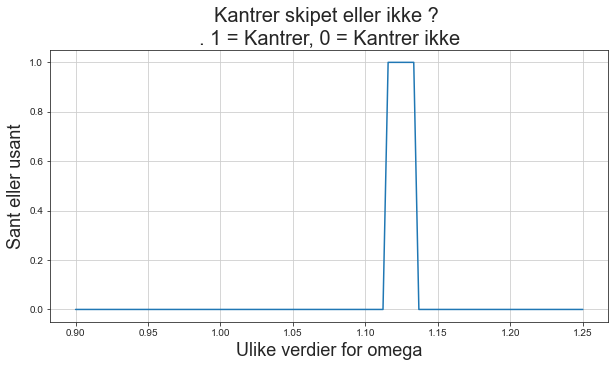

Egenfrekvensen til systemet er: 1.14


In [276]:
#plottefunksjon
def plotteKantringRes(x,t):
    plt.figure()
    plt.plot(x, t) 
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    plt.grid()
    plt.title(f'Kantrer skipet eller ikke ? \n. 1 = Kantrer, 0 = Kantrer ikke', fontsize=20)
    plt.xlabel('Ulike verdier for omega', fontsize=18)
    plt.ylabel('Sant eller usant', fontsize=18)
    plt.show()

plotteKantringRes(wOmega,trueOrFalse)
print("Egenfrekvensen til systemet er: {:.2f}".format(omega))

Her ser vi at under gitte betingelser vil skipet bare kantre for enkelte verdier av $\omega_w$. Det som er verdt å legge merke til er at egenfrekvensen til systemet er 1.14 rad/s, og det er bare verdier for $\omega_w$ som ligger nærme nok denne frekvensen, som vil klare å kantre båten. Det er fordi det oppstår resonans når frekvensene er såpass like hverandre, og dermed vil de kunne svinge i takt slik at veldig store amplituder kan oppnås. Vi kan likevel merke oss at det virker som om det særlig er frekvensverdier som ligger rett under resonansfrekvensen som gir kantring, fremfor høyere verdier. 

### Kaptein krok

Helt til slutt ønsker vi å ta for oss en ny og spennende problemstilling. For å teste de ulike metodene på en kreativ oppgave har vi utvidet vår gamle løser til en ny som vi kaller ode_solverKreativ. Dette er for å inkludere flere funksjoner. Vi bruker likevek RK4 metoden for å løse denne delen, ettersom det ikke er metoden vi nødvendigvis er interessert i nå, men hvordan ulik last vil påvirke stabiliteten til skipet. 

I denne oppgaven har skipet vårt fått en kaptein. Vi kaller han Kaptein Krok. Krok er nokså uforutsigbar og beveger seg litt tilfeldig rundt på skipet. Han har også litt ulike skritt på stegene når han først føler for å bevege på seg. 

Krok lever av å selge fisk. Han tar skipet sitt med ut på sjøen sammen med en bøtte. På tilfeldige tidspunkt hopper det fisk opp i båten, og Krok fanger alle i bøtten sin. 

Første dag fanger Krok ingen fisk. Krok prøver igjen neste dag og treffer på en fiskestim! Mange fisk hopper opp i båten, og Krok fanger de. Dessverre gjør dette at han kantrer.

Krok beveger seg hver femtiende iterasjon, og vi bruker random-funksjon for å implementere skrittene. De kan være opp til 0.5 meter, og i en vilkårlig retning. Fiskene kan veie opp til 50 kg og det er 20% sjanse for at en fisk hopper opp i båten hver iterasjon. 


In [247]:

def ode_solverKreativ(f, t0, tend, warr, dt, mL, last = False, gjerde = True, method=rungeKuttaMetode2, fisk = True):

    #Initializing: 
    w_num = np.array([warr])    # Array for the solution y 
    t_num = np.array([t0])    # Array for the x-values

    tn = t0                # Running values for x and y
    wn = warr 
    antallFisk = 0
    i = 0

    #if fisk:
        #m0 = mL
        #print(f'Startverdien for last er {mL}')
    
    while tn < tend:# - 1.e-10: 
        i+=1
        lagre = wn[6] 
        tn, wn = method(f, tn, wn, dt, mL)    # Do one step by the method of choice
        wn[6], wn[7] = lagre, 0
        #Siden vi ikke ønsker at metoden skal oppdatere skittene til Kapteinen lagrer vi disse før metoden
        #og legger de tilbake i vektoren etterpå. Farten hans er ikke relevant og settes til null.

        if i%50 == 0: #Mannen vil bevege seg hver 50. iterasjon 
            skritt = (np.random.randint(1,10+1)*(np.random.randint(0,2)*2-1))*0.05 #Velger random tall mellom -0.5 og 0.5, utenom null 
            #Dette beveger vår kaptein i en tilfeldig retning og med tilfeldig skrittlengde
            wn[6] += skritt #Oppdaterer kapteinens posijon
        if fisk:
            if np.random.random() < 0.2: #20% sjanse for at det kommer fisk
                mLFisk = np.random.random()*50 #Fisken veier noe tilfeldig opp til 50kg
                mL += mLFisk #Vekten av last blir nå Kaptein + den nye fisken han fanget
                antallFisk += 1

        if last: 
            if abs(wn[6])>=R: #and abs(wn[6])<2*R: #Dersom lasten har falt av vil massen settes til null
                if gjerde:  #Ulik håndtering av lasten hvis det er gjerde eller ikke. 
                    if wn[6] < 0: 
                        wn[6] = -R
                        wn[7] = 0
                    if wn[6] > 0:
                        wn[6] = R
                        wn[7] = 0
                else:  #lasten flyr av
                    if wn[6] < 0:
                        mL = 0
                        wn[6] = -2*R #Massens posisjon settes til 2*R for å vise at den 
                    if wn[6] > 0: 
                        mL = 0
                        wn[6] = 2*R
        # Extend the arrays for x and y
        dYc = wn[2]-yC0
        gamma = 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(wn[0]))+dYc/R)
        kanteKrav = (np.pi- gamma)/2 
        if wn[0] > kanteKrav:
            kanteTid = tn #Tiden skipet kantrer
            if wn[0] > 0: #Kantrer med klokken (Tippe til høyre)
                fortegn = 1
            else: 
                fortegn = -1
            while tn < tend:
                wNye = np.zeros(len(wn))
                wNye[0] = np.pi/2*fortegn
                wNye[-1] = kanteTid #Siste element vil bli kantretiden, slik at vi kan hente denne ut senere
                w_num = np.concatenate((w_num, (np.array([wNye]))))
                t_num = np.append(t_num,tn)
                tn, wn1 = method(f, tn, wn, dt, mL)
            #if fisk:
                #print(f'Sluttverdien for last er {mL}, dvs at vi har økt vekten med {mL-m0}. \n Antall fisk er {antallFisk}')
            return t_num, w_num
        w_num = np.concatenate((w_num, (np.array([wn]))))
        t_num = np.append(t_num,tn)
        if tn > tend: #Relevant for oppgave 1h, omgjør siste iterasjon slik at denne er lik vår tend. 
            tn, wn = method(f, tend, wn, dt, mL)  
            w_num[-1] = wn
            t_num[-1] = tend
        
    #if fisk:
        #print(f'Sluttverdien for last er {mL}, dvs at vi har økt vekten med {mL-m0}. \n Antall fisk er {antallFisk}')
    return t_num, w_num


def fvecFriksjonKreativ(t, w, mL):
    '''t: tiden
    w: w-array. 8 elementer. 
    mL: massen til lasten 
    returnerer: ny w-array'''

    mNy = m + mL    #Ny masse til 
    sigmaNy = mNy/A_s #massetettheten til skipet per lengdeenhet (kg/m^2)
    betaNy, nitNy = bisection(f, a, b, sigmaNy, tol=1.e-6) #Vinkelen for vannkontakten ved likevekt. Denne er konstant gjennom hele ODE_solverGjerde
    dYc = w[2]-yC0
    gamma = 2*np.arccos(np.cos(betaNy/2)-(4/(3*np.pi))*(1-np.cos(w[0]))+dYc/R)   #Vinkelen for vannkontakt
    A = 1/2*R**2*(gamma-np.sin(gamma))  #Arealet til det fortrengte vannet
    Fb = A*sigma0*g
    Ic = 1/2*m*R**2*(1-32/(9*(np.pi)**2))
    friksjon = -kf*R*gamma*w[1]
    Fw = F0*np.cos(ww*t)
    arr = np.array([w[1],(-Fb*h*np.sin(w[0])+friksjon*(w[2]-R*(np.cos(gamma/2)-1))-mL*g*np.cos(w[0])*w[6]+Fw*w[2])/Ic,    w[3],    (-m*g+A*sigma0*g-mL*g*(np.cos(w[0]))**2)/m,   w[5],   (-kf*R*gamma*w[1]+F0*np.cos(ww*t)+ mL*g*np.cos(w[0])*np.sin(w[0]))/m, w[6], 0])   
    return arr   #np.array([w, dw/dt, vy, dvy/dt, vx, dvx/dt, vL, dvL/dt])


In [248]:
def hentePosisjon(wk): #Henter ut x-posisjonen til mannen
    sl = np.zeros(len(wk))
    for i in range(len(wk)):
        sl[i] = wk[i][6]
    return sl

wf = np.array([0, 0.4, yC0, 0, 0, 0, 0, 0])
tKrok, wKrok = ode_solverKreativ(fvecFriksjonKreativ, 0, 70, wf, 0.01, 1000, last = True, gjerde = True, method=rungeKuttaMetode2, fisk = False)
tFisk, wFisk = ode_solverKreativ(fvecFriksjonKreativ, 0, 70, wf, 0.01, 1000, last = True, gjerde = True, method=rungeKuttaMetode2)

KrokX = hentePosisjon(wKrok)
KrokXF = hentePosisjon(wFisk)

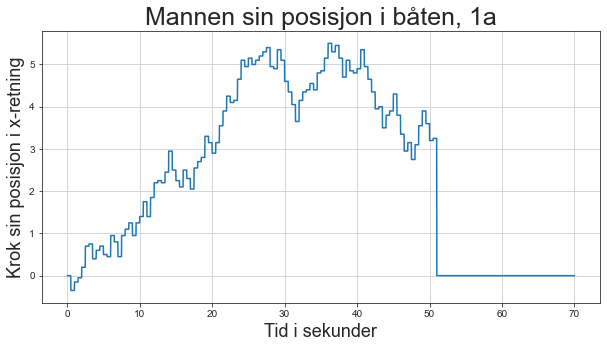

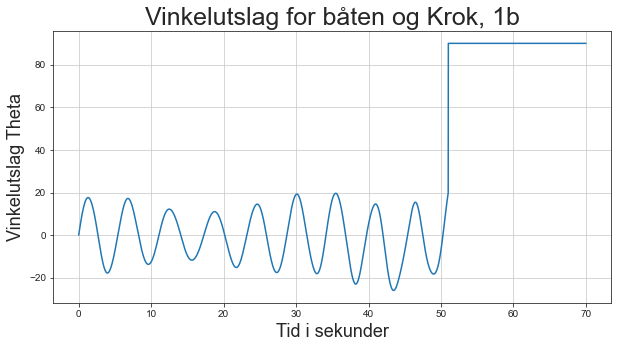

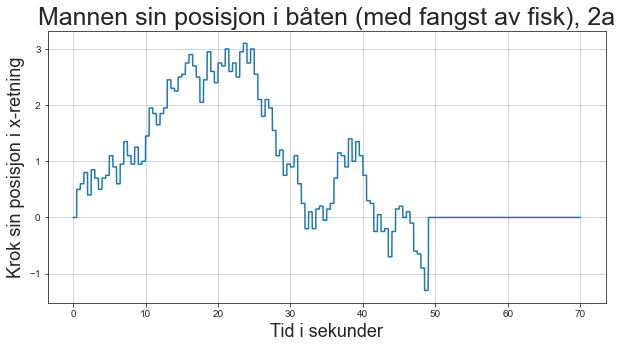

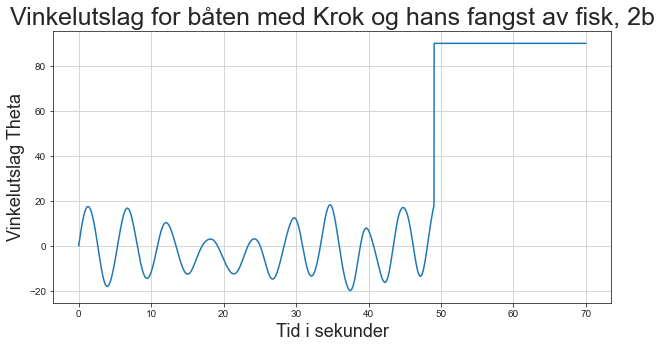

In [249]:
def plotteThetaKreativ(tk, w, title):
    vinkelen = hentTheta(w)
    plt.figure()
    plt.plot(tk, vinkelen)
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    plt.xlabel("Tid i sekunder", fontsize = 18)
    plt.ylabel("Vinkelutslag Theta", fontsize = 18)
    plt.title(title, fontsize = 25)
    plt.show()

def plotteMannenKreativ(tk, sl, title):
    plt.figure()
    plt.plot(tk, sl)
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    plt.xlabel("Tid i sekunder", fontsize = 18)
    plt.ylabel("Krok sin posisjon i x-retning", fontsize = 18)
    plt.title(title, fontsize = 25)
    plt.show()

plotteMannenKreativ(tKrok, KrokX, "Mannen sin posisjon i båten, 1a")
plotteThetaKreativ(tKrok, wKrok, "Vinkelutslag for båten og Krok, 1b")

plotteMannenKreativ(tFisk, KrokXF, "Mannen sin posisjon i båten (med fangst av fisk), 2a")
plotteThetaKreativ(tFisk, wFisk, "Vinkelutslag for båten med Krok og hans fangst av fisk, 2b")

I disse to plottene har Krok dratt ut med skipet uten å fange fisk. I plott 1a ser vi Kroks bevegelse over skipet som funksjon av tiden. Han beveger seg tilfeldig. Plott 1b er skipets vinkel som funksjon av tiden. Skipet kantrer ved rundt 51 sekunder.

Plott 2a er igjen Kroks bevegelse over skipet. 2b er vinkelen til båten som funksjon av tiden. En tyngre last vil være med på å forstyrre skipet ytterligere så vi forventer at båten kantrer tidligere når Krok fanger fisk enn uten. Dette stemmer med plottet, båten kantrer etter rundt 49 sekunder, altså 2 sekunder tidligere enn uten fisk. 

Selv om tyngre last kan bety en mer ustabil båt, vil det i noen tilfeller ha motsatt effekt. Siden Krok beveger seg helt tilfeldig er det mulig han befinner seg på riktig sted til riktig tid. Da kan en økt masse faktisk være med på å stabilisere båten. 

Men siden vi har med tilfeldige tall å gjøre vil ikke ett plott bekrefte dette. Vi regner derfor ut et gjennomsnitt for når båten kantrer ved 100 kjøringer. Funksjonen skriver ut tallene til oss. 

Her ser vi at gjennomsnittelig vil båten kantre 5 sekunder tidligere når Krok fanger fisk enn ikke. 

Vi har satt Krok sin masse til 1000 kg. Dette er urealistisk at en kaptein veier, men nødvendig for å få tydelige resultater og kantring da skipet vårt en nokså stødig.

Grunnen til at vi valgte å gjøre denne kreative oppgaven er fordi selv om vi har tatt oss noen kreative friheter syntes vi det er en nokså realistisk situasjon. Når man skal studere et skips stabilitet er det relevant å se på tilfeldig bevegelse. Alle mennesker er uforutsigbare og vi kan med liten sannsynlighet vite hvor de har tenkt å bevege seg. Et skip burde derfor tåle all slags tilfeldig bevegelse uten å kantre. 



In [253]:
def gjennomsnitt():
    GjFisk, GjUFisk = 0, 0
    antallGanger = 100
    for i in range(antallGanger): #Får 100 verdier
        tFisk, wFisk = ode_solverKreativ(fvecFriksjonKreativ, 0, 80, wf, 0.01, 1000, last = True, gjerde = True, method=rungeKuttaMetode2)
        tUtenFisk, wUtenFisk = ode_solverKreativ(fvecFriksjonKreativ, 0, 80, wf, 0.01, 1000, last = True, gjerde = True, method=rungeKuttaMetode2, fisk = False)
        if wFisk[-1][0] == abs(np.pi/2): #Hvis båten har kantret
            GjFisk += wFisk[-1][-1] #Legg til tiden dette skjedde
        if wUtenFisk[-1][0] == abs(np.pi/2):
            GjUFisk += wUtenFisk[-1][-1]
    return GjFisk/antallGanger, GjUFisk/antallGanger #Returner gjennomsnittet

gjF, gjU = gjennomsnitt()


In [254]:
print("Gjennomsnitts tid til kantring med fisk er: {:.2f}".format(gjF))
print("Gjennomsnitts tid til kantring uten fisk er: {:.2f}".format(gjU))

Gjennomsnitts tid til kantring med fisk er: 45.52
Gjennomsnitts tid til kantring uten fisk er: 50.47


### Konklusjon

Vi har nå sett på en rekke ulike elementer som kan påvirke skipet vårt. For hver oppgave blir det introdusert et nytt element som kan påvirke dynamikken til skipet. Vi startet med det aller enkleste tilfellet hvor massesenteret lå i ro, og det kun var tyngdekraften og oppdriftskraften som virket på båten. Likevel fikk skipet en rotasjon ettersom oppdriftskraften gir et dreiemoment. Da kunne vi studere bevegelsen som en harmonisk oscillator. For å kunne regne på ulike størrelser var det nødvendig å finne likevektsvinkelen, og dermed løse en fikspunktligning ved hjelp av bisection metoden. Vi fikk også testet ut at tilnærmingen $sin(\theta) \approx \theta$ var veldig god for små vinkelutslag. Alt dette gjorde vi først med Euler metoden. Dette er den enkleste metoden, og vi oppdaget ganske raskt at det ikke er den beste. Den ble etter hvert byttet ut med RK4 ettersom denne var både raskere og mer pressis, uten å være særlig vanskelig å implementere. Vi sammenlignet dem i forhold til den analytiske løsningen og så hvordan ordenen til metodene kom til syne i form av feilestimatet. 

Videre utviklet vi koden vår til å ta hensyn til både friksjon, vind, bølger og last. Disse påvirket skipet på ulike måter og det var interessant å se hva som skal til for å få skipet til å kantre. Mye av koden i ode_solveren vår måtte endre seg når disse elementene ble lagt til. Mot slutten testet vi ulike ODE-løsere for å finne ut hvilken som er best. Vi konkluderte med at de høyeste ordens metodene ofte var raskere, og gjerne mest pressise. Grunnen til dette var fordi de kunne hadde større steglengder, og dermed ferre iterasjoner, men likevel opprettholde samme feiltoleranse. Sammenligner vi uten tilpasningsdyktig steglengde (men med en bestemt dt) vil lavere ordens metoder være raskere. Likevel merker vi oss at de høyere ordens metodene er vanskeligere å implementere. Vi brukte bogacki shampine for å finne verdier for $\omega_w$ som ga ressonans (og kantring). Tilslutt testet vi ut hvordan skipet blir påvirket av kaptein Krok sin tilfeldige bevegelse. Særlig merket vi oss at kantringen ble oppnådd tidligere når han i tillegg fanget fisk. 

Alt i alt har vi lært mye om hvordan vi kan løse differensialligninger ved hjelp av numeriske metoder, og hva som er med på å avgjøre pressisjon og kjøretid til kodene. Vi har også fått en god del ny kunnskap om hva som påvirker dynamikken til et skip!

#### Kilder

- Støvneng, "Svevning", http://web.phys.ntnu.no/~stovneng/LEKELAB/Svevning.pdf 

- lest: torsdag 10. mars kl 15:10, © Copyright 2008-2022, The SciPy community, https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#r179348322575-1

- Kværnø, "Numerical solutions of ordinary differential equations", https://www.math.ntnu.no/emner/TMA4320/2022v/pdf/ODE.pdf